# Dataset and Problem Statement

This task uses the ILPD (Indian Liver Patient Dataset) found here: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset)

and puts forth the following problem statement:

Death by liver cirrhosis continues to increase, given the increase in alcohol consumption rates, chronic hepatitis infections, and obesity-related liver disease. Notwithstanding the high mortality of this disease, liver diseases do not affect all sub-populations equally. The early detection of pathology is a determinant of patient outcomes, yet female patients appear to be marginalized when it comes to early diagnosis of liver pathology. The dataset comprises 584 patient records collected from the NorthEast of Andhra Pradesh, India. 

The prediction task is to determine whether a patient suffers from liver disease based on the information about several biochemical markers, including albumin and other enzymes required for metabolism.

### 1. Data Understanding and Preprocessing:
1.  Load the dataset and provide a brief summary of the data, including the number of records and features.
2. Drop out 15% of the ALB and A/G Ratio to create artificial missing values
3. Use an imputation technique to handle the previously created missing values
4. Perform data cleaning if necessary (e.g., dealing with outliers, encoding categorical variables).
6. Split the dataset into training and testing sets.
   
#### Data & Preprocessing Questions:

- What are the main characteristics of the dataset? How many features and records are there? What is the target variable?
- How did you handle missing values in the dataset?
- What techniques did you use to clean and preprocess the data?

In [1]:
# Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, roc_auc_score, roc_curve


In [2]:
# Load ILPD as a pandas data frame per the instructions on ILPD website
# fetch dataset 
ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225) 
  
# data (as pandas dataframes) 
X = ilpd_indian_liver_patient_dataset.data.features 
y = ilpd_indian_liver_patient_dataset.data.targets 

# metadata 
print(ilpd_indian_liver_patient_dataset.metadata) 
  
# variable information 
print(ilpd_indian_liver_patient_dataset.variables)

{'uci_id': 225, 'name': 'ILPD (Indian Liver Patient Dataset)', 'repository_url': 'https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/225/data.csv', 'abstract': 'Death by liver cirrhosis continues to increase, given the increase in alcohol consumption rates, chronic hepatitis infections, and obesity-related liver disease. Notwithstanding the high mortality of this disease, liver diseases do not affect all sub-populations equally. The early detection of pathology is a determinant of patient outcomes, yet female patients appear to be marginalized when it comes to early diagnosis of liver pathology. \nThe dataset comprises 584 patient records collected from the NorthEast of Andhra Pradesh, India.\nThe prediction task is to determine whether a patient suffers from liver disease based on the information about several biochemical markers, including albumin and other enzymes required for metabolism.\n', 'area': 'He

In [3]:
# Load the dataset and provide a brief summary of the data, including the number of records and features.
print("Summary:\n\n", ilpd_indian_liver_patient_dataset.metadata['additional_info']['summary'], "\n\n")

print("There are ", len(X.columns.tolist()), " Features. ", X.columns.tolist(), 
      ". The target variable is: ", ilpd_indian_liver_patient_dataset.metadata.target_col)

print("There are ", ilpd_indian_liver_patient_dataset.metadata.num_instances, " records")

Summary:

 This data set contains records of 416 patients diagnosed with liver disease and 167 patients without liver disease. This information is contained in the class label named 'Selector'.  There are 10 variables per patient: age, gender, total Bilirubin, direct Bilirubin, total proteins, albumin, A/G ratio, SGPT, SGOT and Alkphos. Of the 583 patient records, 441 are male, and 142 are female. 

The current dataset has been used to study 
- differences in patients across US and Indian patients that suffer from liver diseases.
- gender-based disparities in predicting liver disease, as previous studies have found that biochemical markers do not have the same effectiveness for male and female patients.
 


There are  10  Features.  ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio'] . The target variable is:  ['Selector']
There are  583  records


In [4]:
# 2. Drop out 15% of the ALB and A/G Ratio to create artificial missing values

# Columns to create missing values
column_names = ['ALB', 'A/G Ratio']
np.random.seed(42)  # For reproducibility

for colm in column_names:
    # Print current number of NaNs
    print("BEFORE: Missing Vals in ", colm, " ", X[colm].isna().sum())
    
    # Calculate the number of elements to replace
    num_elements = X[colm].size
    num_to_replace = int(0.15 * num_elements)  # 15% of the column size
    
    # Randomly select indices to replace
    replace_indices = np.random.choice(X.index, num_to_replace, replace=False)
    
    # Replace selected elements with 0
    X.loc[replace_indices, colm] = np.nan
    print("AFTER: Missing Vals in ", colm, " ", X[colm].isna().sum())

print("X with 15% of missing vals:")
X.head()

BEFORE: Missing Vals in  ALB   0
AFTER: Missing Vals in  ALB   87
BEFORE: Missing Vals in  A/G Ratio   4
AFTER: Missing Vals in  A/G Ratio   91
X with 15% of missing vals:


,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,NaN
2,62,Male,7.3,4.1,490,60,68,7.0,NaN,0.89
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40


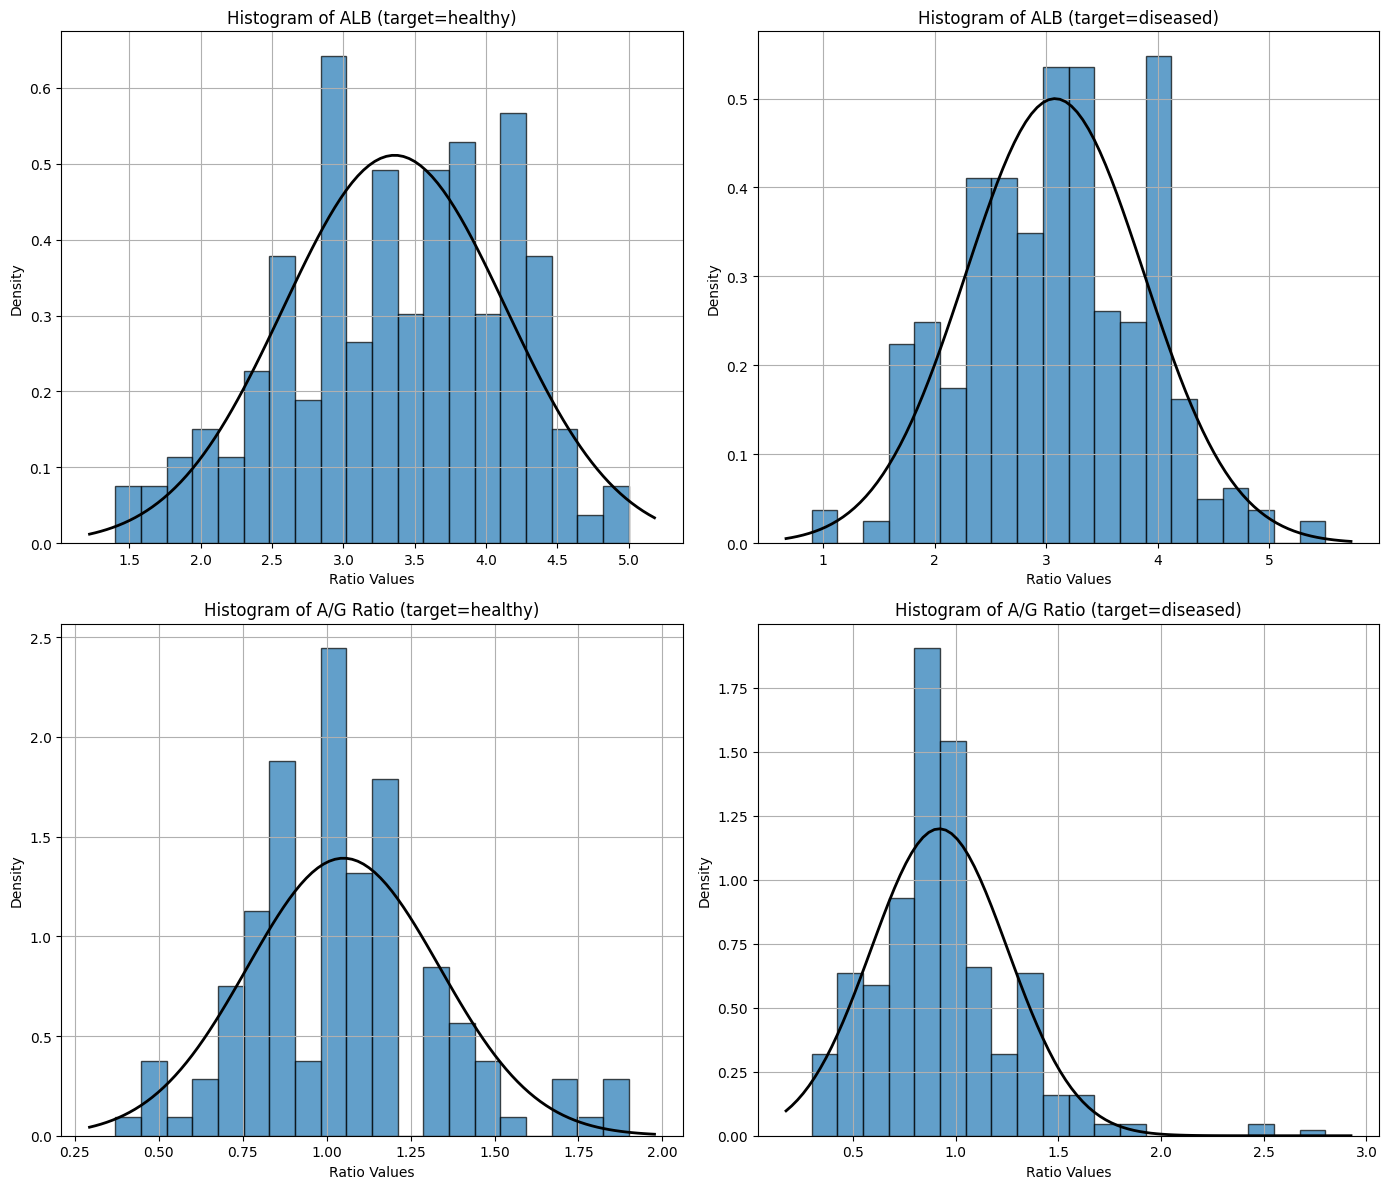

In [5]:
# 3. Use an imputation technique to handle the previously created missing values
# We may want to impute differently given the target disease state (2 healthy or 1 diseased) 
# The easiest way to impute data is to take the mean or median of the set, but this can skew the data if the data is not evenly distributed.
# So, let's first check the distribution.

# Separate data based on target value
X['target'] = y['Selector']
X_target_0 = X[X['target'] == 2] # healthy, will convert to 0 later in the notebook
X_target_1 = X[X['target'] == 1]

# Create a figure with four subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot for 'ALB' where target = 2; healthy
mu_alb_0, std_alb_0 = norm.fit(X_target_0['ALB'].dropna())
axs[0, 0].hist(X_target_0['ALB'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_alb_0, xmax_alb_0 = axs[0, 0].get_xlim()
x_alb_0 = np.linspace(xmin_alb_0, xmax_alb_0, 100)
p_alb_0 = norm.pdf(x_alb_0, mu_alb_0, std_alb_0)
axs[0, 0].plot(x_alb_0, p_alb_0, 'k', linewidth=2)
axs[0, 0].set_title('Histogram of ALB (target=healthy)')
axs[0, 0].set_xlabel('Ratio Values')
axs[0, 0].set_ylabel('Density')
axs[0, 0].grid(True)

# Plot for 'ALB' where target = 1; diseased
mu_alb_1, std_alb_1 = norm.fit(X_target_1['ALB'].dropna())
axs[0, 1].hist(X_target_1['ALB'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_alb_1, xmax_alb_1 = axs[0, 1].get_xlim()
x_alb_1 = np.linspace(xmin_alb_1, xmax_alb_1, 100)
p_alb_1 = norm.pdf(x_alb_1, mu_alb_1, std_alb_1)
axs[0, 1].plot(x_alb_1, p_alb_1, 'k', linewidth=2)
axs[0, 1].set_title('Histogram of ALB (target=diseased)')
axs[0, 1].set_xlabel('Ratio Values')
axs[0, 1].set_ylabel('Density')
axs[0, 1].grid(True)

# Plot for 'A/G Ratio' where target = 2; healthy
mu_ag_0, std_ag_0 = norm.fit(X_target_0['A/G Ratio'].dropna())
axs[1, 0].hist(X_target_0['A/G Ratio'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_ag_0, xmax_ag_0 = axs[1, 0].get_xlim()
x_ag_0 = np.linspace(xmin_ag_0, xmax_ag_0, 100)
p_ag_0 = norm.pdf(x_ag_0, mu_ag_0, std_ag_0)
axs[1, 0].plot(x_ag_0, p_ag_0, 'k', linewidth=2)
axs[1, 0].set_title('Histogram of A/G Ratio (target=healthy)')
axs[1, 0].set_xlabel('Ratio Values')
axs[1, 0].set_ylabel('Density')
axs[1, 0].grid(True)

# Plot for 'A/G Ratio' where target = 1; diseased
mu_ag_1, std_ag_1 = norm.fit(X_target_1['A/G Ratio'].dropna())
axs[1, 1].hist(X_target_1['A/G Ratio'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_ag_1, xmax_ag_1 = axs[1, 1].get_xlim()
x_ag_1 = np.linspace(xmin_ag_1, xmax_ag_1, 100)
p_ag_1 = norm.pdf(x_ag_1, mu_ag_1, std_ag_1)
axs[1, 1].plot(x_ag_1, p_ag_1, 'k', linewidth=2)
axs[1, 1].set_title('Histogram of A/G Ratio (target=diseased)')
axs[1, 1].set_xlabel('Ratio Values')
axs[1, 1].set_ylabel('Density')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
# 3. Use an imputation technique to handle the previously created missing values
# Mean or Median imputation would be acceptable since generally, most of the data is near the mean (mu.) 
# However, this dataset is rather small and the relationship between the features is important, so let's impute using KNN

# Columns we want to impute
columns_to_impute = ['ALB', 'A/G Ratio']
df_to_impute = X[columns_to_impute]

# KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=columns_to_impute)

# Replace the original columns with the imputed columns
X.loc[:, columns_to_impute] = df_imputed

# Check our work:
print("Total missing vals: ", X['ALB'].isna().sum() + X['A/G Ratio'].isna().sum())

Total missing vals:  0


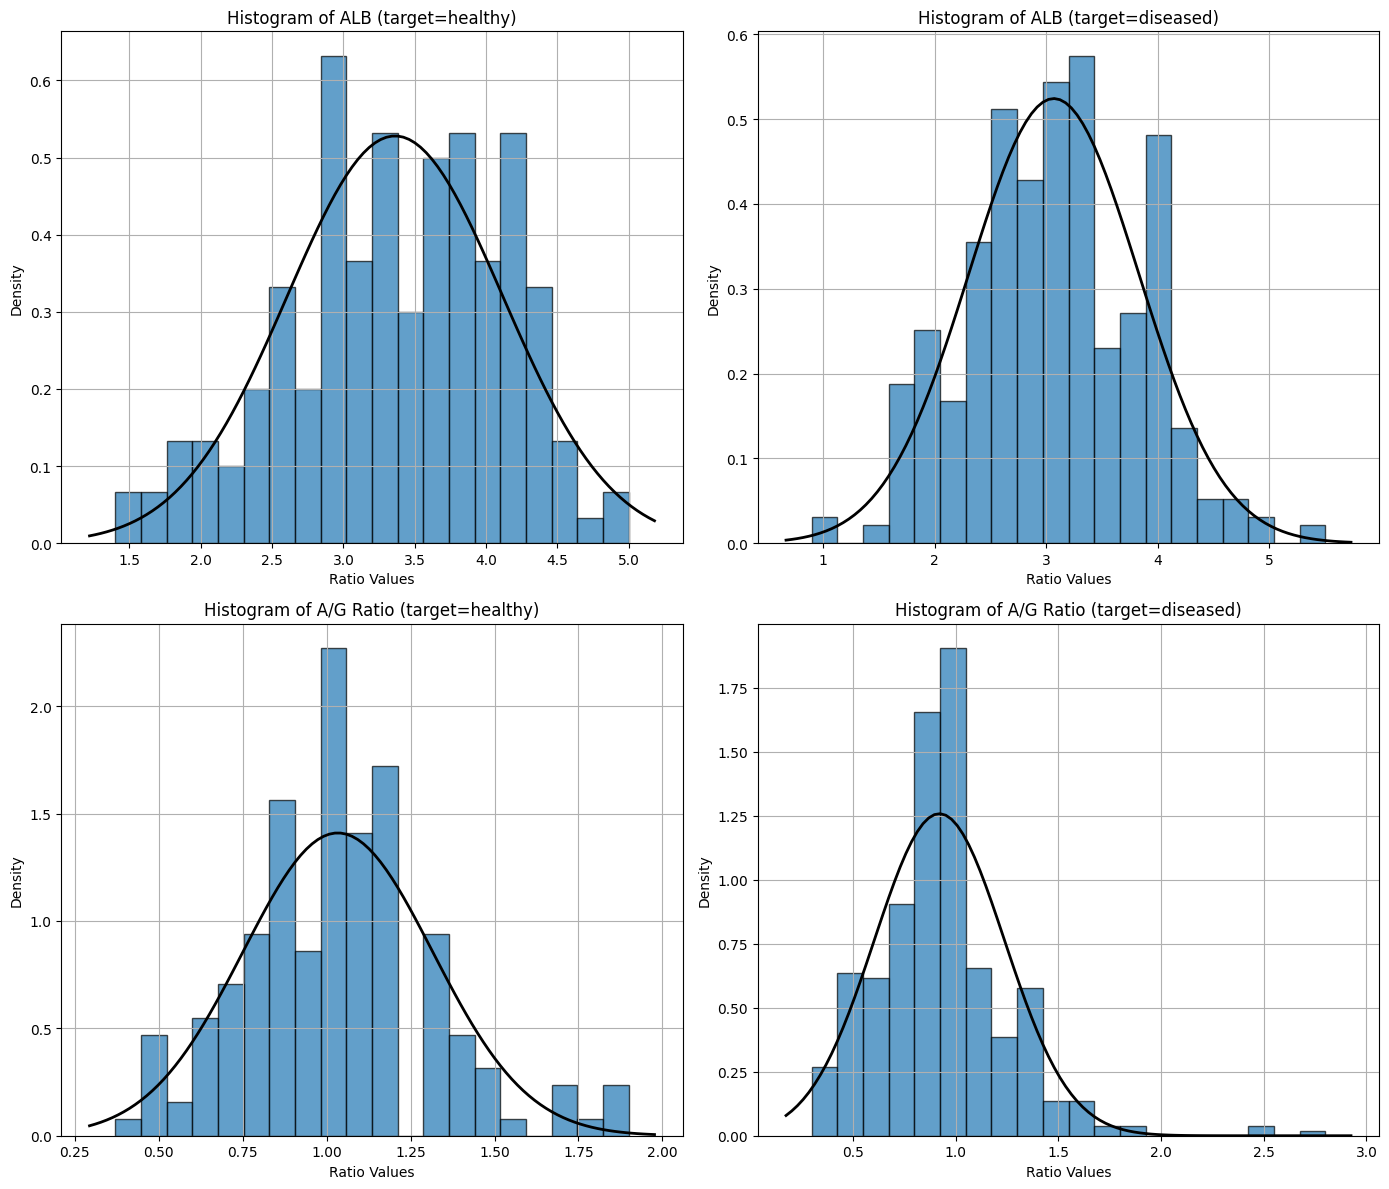

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,target
0,65,Female,0.7,0.1,187,16,18,6.8,3.30,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.20,0.92,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.62,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.40,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.40,0.40,1


In [7]:
# Let's do a sanity check on our distributions now that we have the imputations from KNN
# Separate data based on target value
X['target'] = y['Selector']
X_target_0 = X[X['target'] == 2] # healthy, will convert to 0 later in the notebook
X_target_1 = X[X['target'] == 1]

# Create a figure with four subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot for 'ALB' where target = 2; healthy
mu_alb_0, std_alb_0 = norm.fit(X_target_0['ALB'].dropna())
axs[0, 0].hist(X_target_0['ALB'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_alb_0, xmax_alb_0 = axs[0, 0].get_xlim()
x_alb_0 = np.linspace(xmin_alb_0, xmax_alb_0, 100)
p_alb_0 = norm.pdf(x_alb_0, mu_alb_0, std_alb_0)
axs[0, 0].plot(x_alb_0, p_alb_0, 'k', linewidth=2)
axs[0, 0].set_title('Histogram of ALB (target=healthy)')
axs[0, 0].set_xlabel('Ratio Values')
axs[0, 0].set_ylabel('Density')
axs[0, 0].grid(True)

# Plot for 'ALB' where target = 1; diseased
mu_alb_1, std_alb_1 = norm.fit(X_target_1['ALB'].dropna())
axs[0, 1].hist(X_target_1['ALB'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_alb_1, xmax_alb_1 = axs[0, 1].get_xlim()
x_alb_1 = np.linspace(xmin_alb_1, xmax_alb_1, 100)
p_alb_1 = norm.pdf(x_alb_1, mu_alb_1, std_alb_1)
axs[0, 1].plot(x_alb_1, p_alb_1, 'k', linewidth=2)
axs[0, 1].set_title('Histogram of ALB (target=diseased)')
axs[0, 1].set_xlabel('Ratio Values')
axs[0, 1].set_ylabel('Density')
axs[0, 1].grid(True)

# Plot for 'A/G Ratio' where target = 2; healthy
mu_ag_0, std_ag_0 = norm.fit(X_target_0['A/G Ratio'].dropna())
axs[1, 0].hist(X_target_0['A/G Ratio'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_ag_0, xmax_ag_0 = axs[1, 0].get_xlim()
x_ag_0 = np.linspace(xmin_ag_0, xmax_ag_0, 100)
p_ag_0 = norm.pdf(x_ag_0, mu_ag_0, std_ag_0)
axs[1, 0].plot(x_ag_0, p_ag_0, 'k', linewidth=2)
axs[1, 0].set_title('Histogram of A/G Ratio (target=healthy)')
axs[1, 0].set_xlabel('Ratio Values')
axs[1, 0].set_ylabel('Density')
axs[1, 0].grid(True)

# Plot for 'A/G Ratio' where target = 1; diseased
mu_ag_1, std_ag_1 = norm.fit(X_target_1['A/G Ratio'].dropna())
axs[1, 1].hist(X_target_1['A/G Ratio'].dropna(), bins=20, edgecolor='k', alpha=0.7, density=True)
xmin_ag_1, xmax_ag_1 = axs[1, 1].get_xlim()
x_ag_1 = np.linspace(xmin_ag_1, xmax_ag_1, 100)
p_ag_1 = norm.pdf(x_ag_1, mu_ag_1, std_ag_1)
axs[1, 1].plot(x_ag_1, p_ag_1, 'k', linewidth=2)
axs[1, 1].set_title('Histogram of A/G Ratio (target=diseased)')
axs[1, 1].set_xlabel('Ratio Values')
axs[1, 1].set_ylabel('Density')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

X.head()

In [8]:
# Imputation looks good! Let's move on to cleaning up the data.
# 4. Perform data cleaning if necessary (e.g., dealing with outliers, encoding categorical variables).
# Check our feature types:
columns_to_print = ['name', 'type']
print(ilpd_indian_liver_patient_dataset.variables[columns_to_print])

# 4.1 Let's check for any more missing data
print(X.isnull().sum(), "\n")

# 4.2 Let's check for weirdness in our categorical variables, e.g., Male, M, MALE
print(X.Gender.unique()) # Surprisingly clean!

# 4.2 Let's also check for any imbalances in Gender and our target 
# Count the occurrences in the 'Gender' column
count_male = X['Gender'].value_counts().get("Male", 1)
count_female = X['Gender'].value_counts().get("Female", 0)

# Count the occurrences in the 'target' column
count_healthy = X['target'].value_counts().get(2)
count_diseased = X['target'].value_counts().get(1)

# Print the counts
print("Male: ", count_male, "Female: ", count_female) # Gender counts
print("Healthy: ", count_healthy, "Diseased: ", count_diseased) # Health status counts

         name        type
0         Age     Integer
1      Gender      Binary
2          TB  Continuous
3          DB  Continuous
4     Alkphos     Integer
5        Sgpt     Integer
6        Sgot     Integer
7          TP  Continuous
8         ALB  Continuous
9   A/G Ratio  Continuous
10   Selector      Binary
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
target       0
dtype: int64 

['Female' 'Male']
Male:  441 Female:  142
Healthy:  167 Diseased:  416


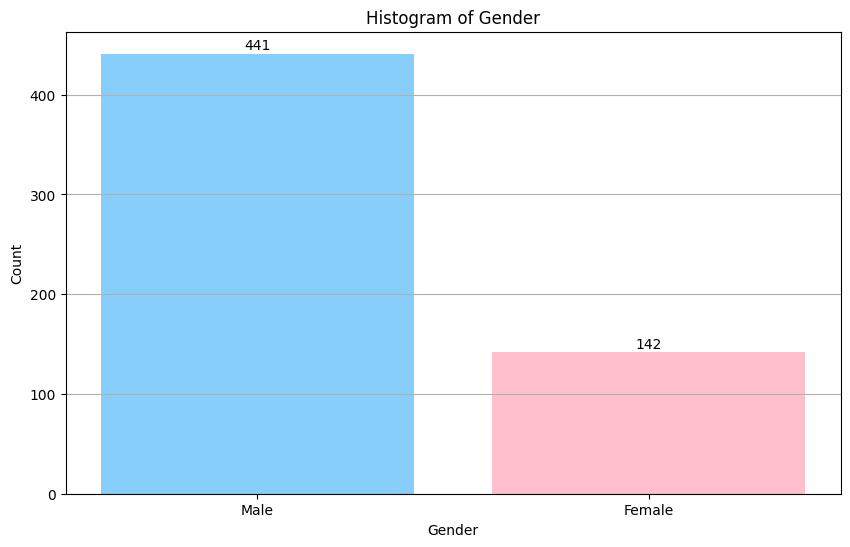

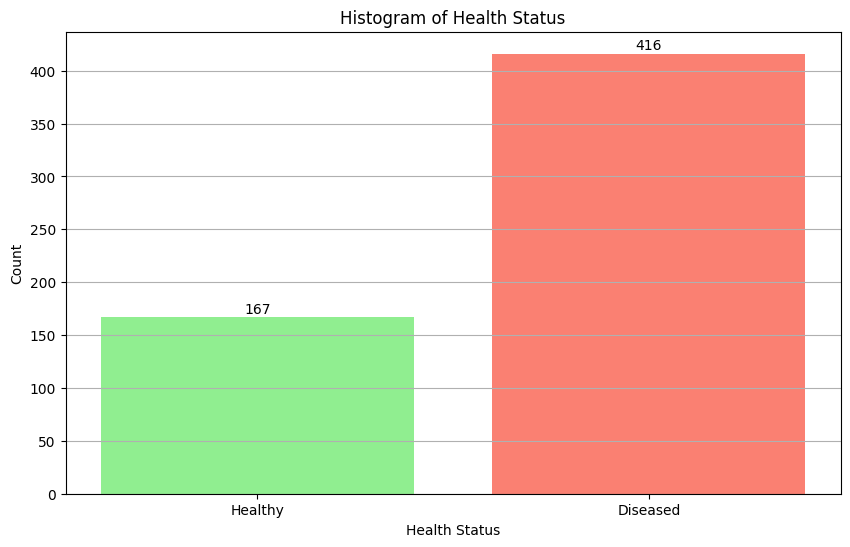

In [9]:
# Create a bar plot for Gender
labels_gender = ['Male', 'Female']
counts_gender = [count_male, count_female]

plt.figure(figsize=(10, 6))
plt.bar(labels_gender, counts_gender, color=['lightskyblue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Histogram of Gender')
plt.grid(axis='y')

# Display the counts on top of the bars
for i, count in enumerate(counts_gender):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.show()

# Create a bar plot for Health Status
labels_health = ['Healthy', 'Diseased']
counts_health = [count_healthy, count_diseased]

plt.figure(figsize=(10, 6))
plt.bar(labels_health, counts_health, color=['lightgreen', 'salmon'])
plt.xlabel('Health Status')
plt.ylabel('Count')
plt.title('Histogram of Health Status')
plt.grid(axis='y')

# Display the counts on top of the bars
for i, count in enumerate(counts_health):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.show()

In [10]:
# 4.3 Converting Gender to a numerical variable
# Mapping dictionaries
gender_mapping = {'Male': 1, 'Female': 0}
# target 2 = healthy, 1 = diseased UPDATE TO target 0 = healthy, 1 = diseased
# Count: 416 diseased, 167 healthy
target_mapping = {2: 0, 1: 1}

# Converting Gender to a numerical variable
X.loc[:, 'Gender'] = X['Gender'].map(gender_mapping).astype(int)

# Converting target to a binary variable
X.loc[:, 'target'] = X['target'].map(target_mapping).astype(int)
y.loc[:, 'Selector'] = y['Selector'].map(target_mapping).astype(int)

### Data & Preprocessing Questions:
#### What are the main characteristics of the dataset? How many features and records are there? What is the target variable?
There are 10 features: age, gender, total Bilirubin, direct Bilirubin, total proteins, albumin, A/G ratio, SGPT, SGOT and Alkphos
The target variable is called Selector with 1 indicating healthy and 2 indicating diseased, which was converted to healthy: 0; diseased: 1. It is important to note that there is a big imbalance in Males vs. Females in this dataset. I will use SMOTE when we get to the data-splitting phase of this notebook to handle this bias. There is also an imbalance in the target variable. We have many more diseased records than healthy records. I will use this information when making model selection (Ensemble methods handle these imbalances well.) I could also use smote with this, but I hesitate due to overfitting. Finally, I will explore other methods for evaluating our model(s) since accuracy will likely be less effective than F1 Score (for example) in an imbalanced set.

#### How did you handle missing values in the dataset?
Aside from the data I artificially introduced, there was no missing data. For the data I artificially introduced, I used K-nearest Neighbors to impute missing values. I went with this method since the data set was small and I wanted to attempt to preserve relationships between features. 

#### What techniques did you use to clean and preprocess the data?
Luckily, our categorical data (Gender) was already quite clean, otherwise, I would have introduced a standardization method e.g., convert upper before converting to 0, 1. I converted our male (0) and female (1) as those are categorical variables. We will introduce scaling and normalization for our other features later in the notebook. Additionally, I updated the target var "Selector" to O for healthy and 1 for disease. I identified outliers, but I want to keep those as they are important in a disease dataset as potential disease markers. I will check if grouping the outliers by disease vs. healthy gives us more information in EDA. I will also examine the correlation between features & target in EDA. 

### 2. Exploratory Data 
Analysis (EDA):
1. Provide summary statistics for the dataset.
2. Create visualizations to understand the distributions of features and relationships between features and the target variable.
3. Identify any potential correlations between features.

#### EDA Questions:
- What insights did you gain from the EDA? Are there any features that are strongly correlated with the target variable?
- Provide and interpret at least two visualizations that helped you understand the dataset better.

In [11]:
# 1. Provide summary statistics for the dataset. We did this above, but for consistency
# Information on our Feature's data types
print("Feature data info:\n")
print(X.info())
# Decription of the statistics for our Features:
print("Feature stats summary:\n\n")
print(X.describe())

# Information on our target's data types
# Diseased
print("Diseased Target data info:\n")
print(X[X['target'] == 1].describe())

# Healthy
print("Healthy Target data info:\n")
print(X[X['target'] == 0].describe())


# Decription of the statistics for our target:
print("Target data counts:\n")
print("Num healthy: ", y['Selector'].value_counts().get(0, 0))
print("Num diseased: ", y['Selector'].value_counts().get(1, 0))

Feature data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   Sgpt       583 non-null    int64  
 6   Sgot       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G Ratio  583 non-null    float64
 10  target     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None
Feature stats summary:


              Age          TB          DB      Alkphos         Sgpt  \
count  583.000000  583.000000  583.000000   583.000000   583.000000   
mean    44.746141    3.298799    1.486106   290.576329    80.713551   
std     16.189833    6.209522    2.808498   242.9

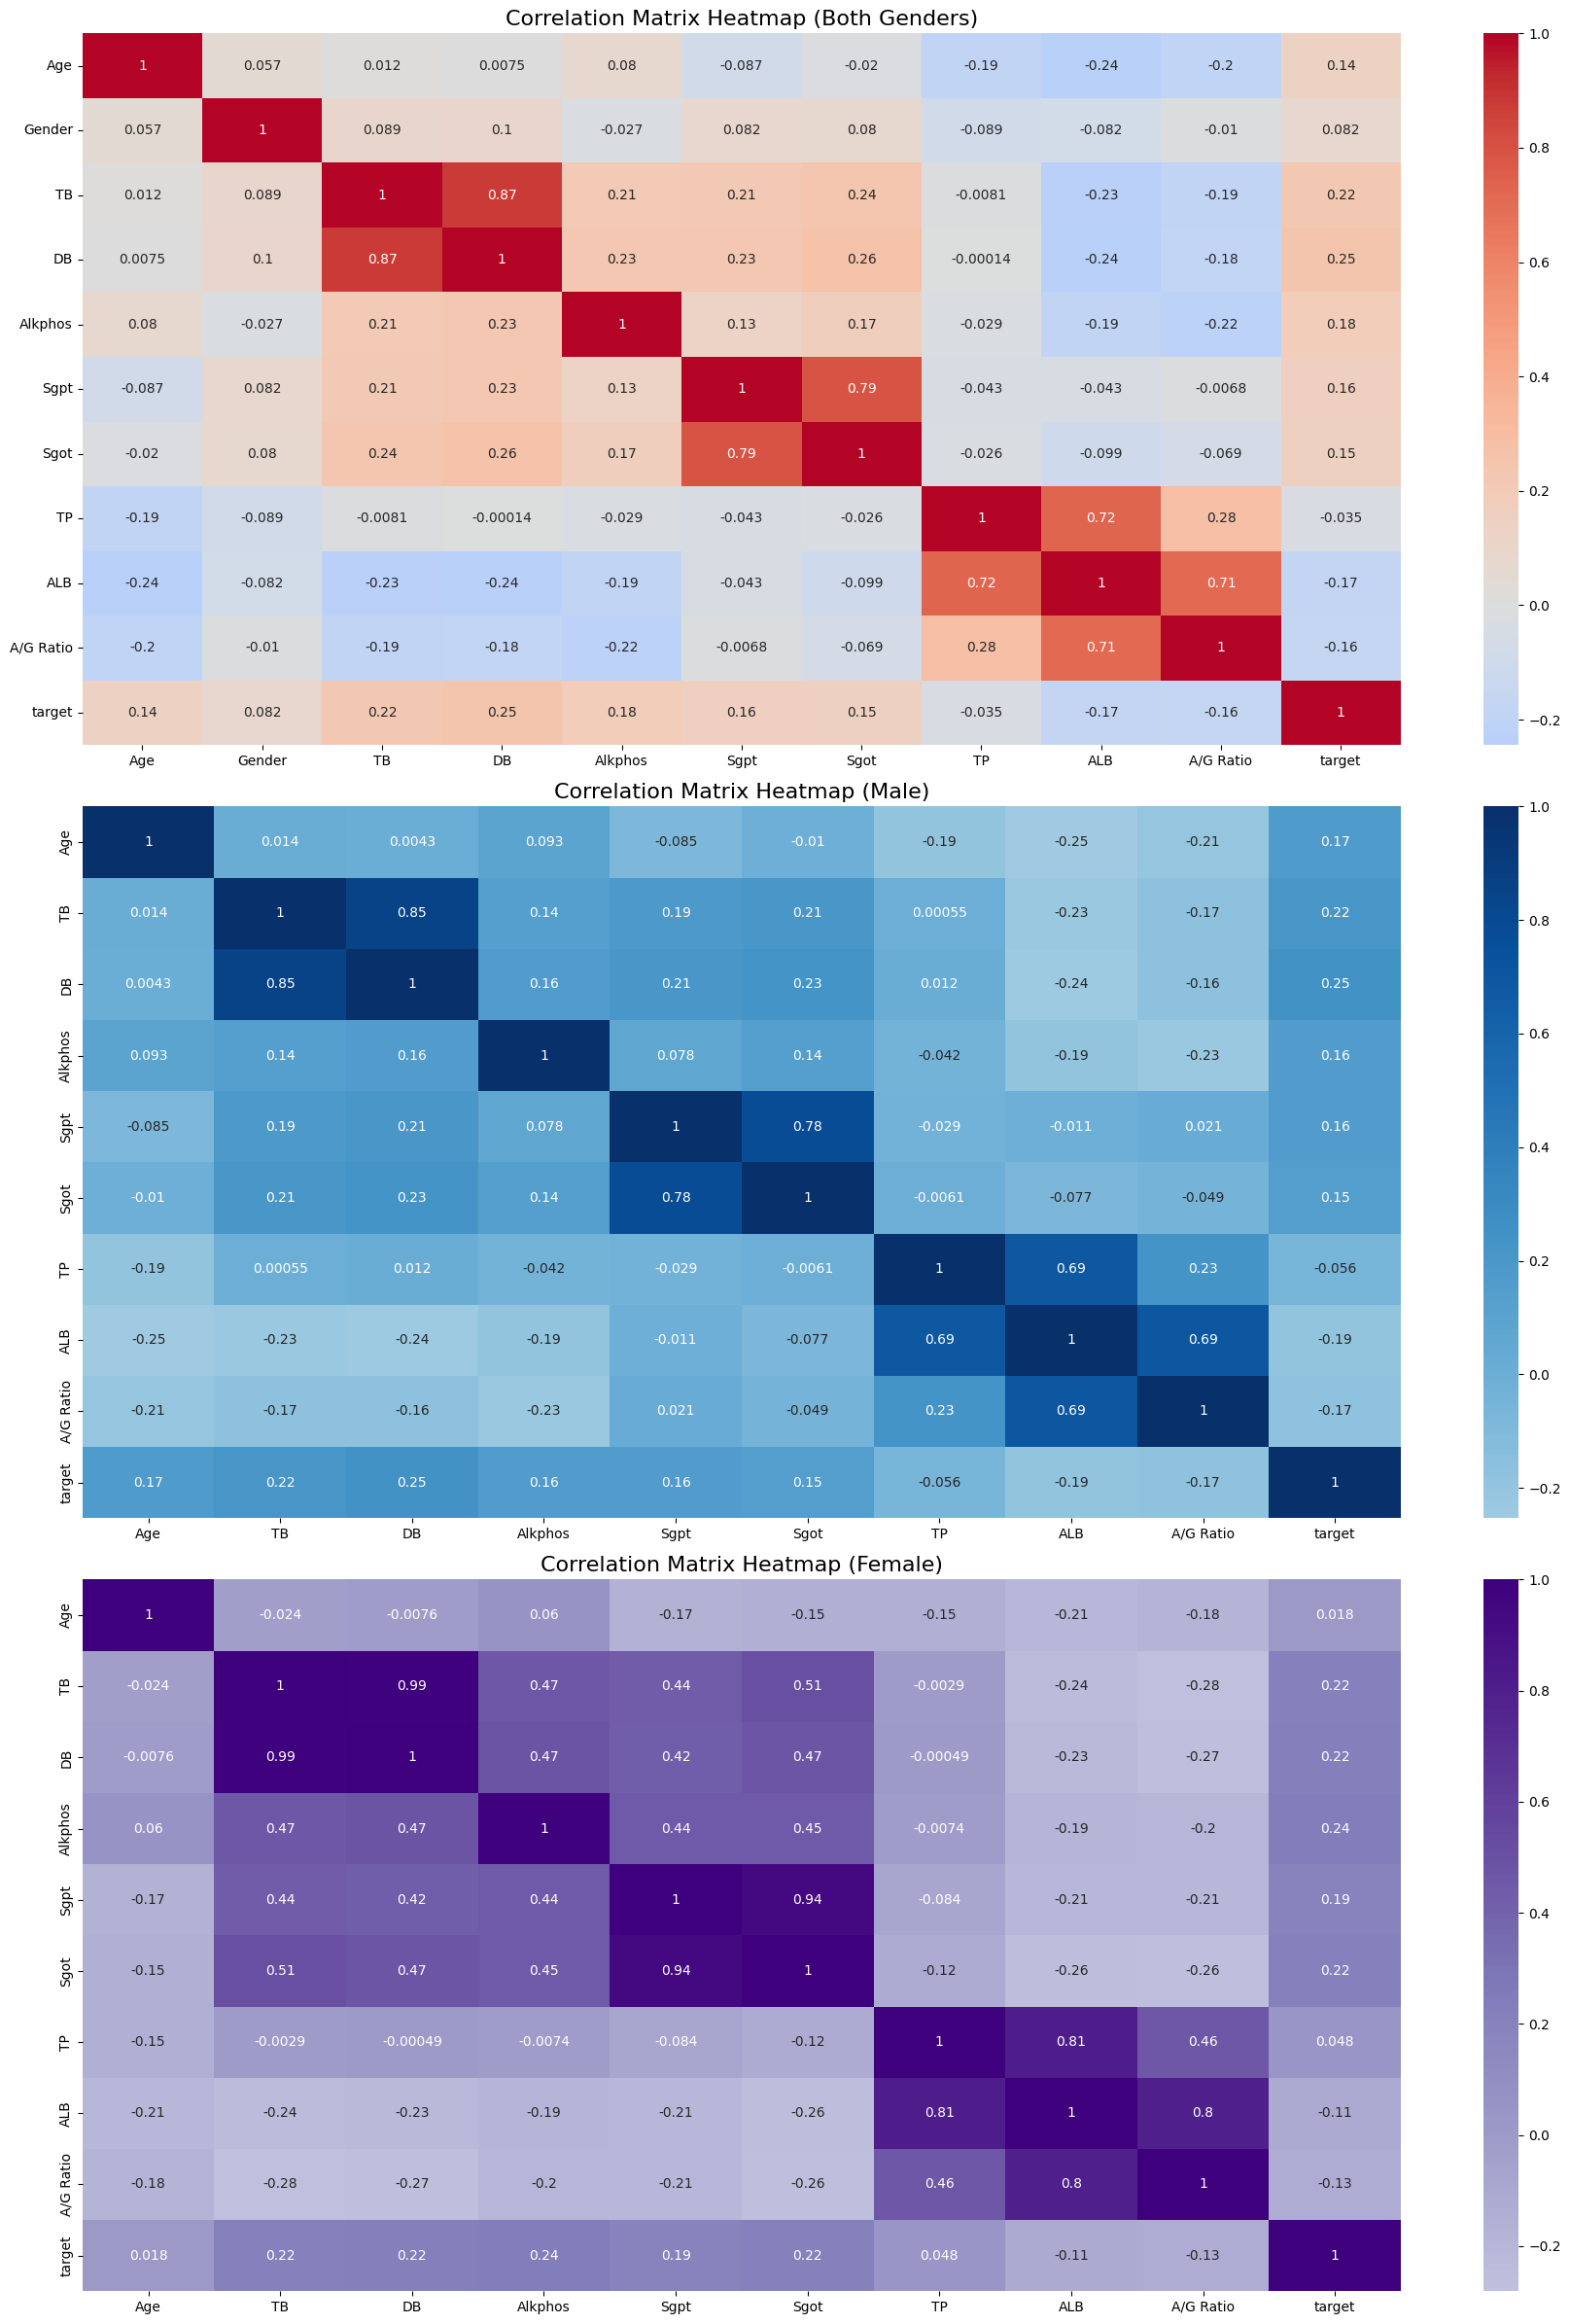

In [12]:
# 2. Create visualizations to understand the distributions of features and relationships between features and the target variable.
# Let's also investigate correlations on a per Gender basis, since the dataset is so biased

# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap for both Genders
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix Heatmap (both Genders)')

# Male = 1
male_X = X.loc[X['Gender'] == 1]
corr_matrix_male = male_X.drop(columns=['Gender']).corr()
# Remove the 'Gender' column before computing the correlation matrix
corr_matrix_male = male_X.drop(columns=['Gender']).corr()

# Female = 0
female_X = X.loc[X['Gender'] == 0]
corr_matrix_female = X.corr()
# Remove the 'Gender' column before computing the correlation matrix
corr_matrix_female = female_X.drop(columns=['Gender']).corr()

# Plot the heatmaps for both Genders and the combined one
fig, axes = plt.subplots(3, 1, figsize=(18, 24))

# Heatmap for both Genders
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 10}, ax=axes[0])
axes[0].set_title('Correlation Matrix Heatmap (Both Genders)', fontsize=16)

# Heatmap for Males
sns.heatmap(corr_matrix_male, annot=True, cmap='Blues', center=0, annot_kws={"size": 10}, ax=axes[1])
axes[1].set_title('Correlation Matrix Heatmap (Male)', fontsize=16)

# Heatmap for Females
sns.heatmap(corr_matrix_female, annot=True, cmap='Purples', center=0, annot_kws={"size": 10}, ax=axes[2])
axes[2].set_title('Correlation Matrix Heatmap (Female)', fontsize=16)

plt.tight_layout()
plt.show()

#### Correlation Summary
3. Identify any potential correlations between features.
   
TB and DB seem to be highly correlated in both genders, but they are nearly the 100% correlated in females. Similarly, Sgpt and Sgot are highly correlated, but especially so in females. Finally, we see that TP vs. ALB, ALB vs A/G Ratio, and A/G Ratio vs TP indicates these features are all highly correlated with each other, but especially so in the female data. 

Notice in the female subset, we also start to see a moderate to strong correlation emerge in the TB vs. Sgot; Sgpt; Alkphos rectangle suggesting there is multicollinearity in the female group for these features. 

In both sets, you can see other weak correlations (0.1 < abs(x) <= 0.3) but these are less concerning than the correlation mentioned above. We don't want to remove all of our Features 
Collinearity in the dataset can make it difficult to estimate the relationship between individual features and the target variable. 

Plan to handle this collinearity in the features 
1. train a model with the features as is so I have a baseline.
2. Then, I will use a couple of different techniques e.g., investigate feature importance, leverage feature selection techniques, add a penalty to the coefficients with regularization, and do some research to determine if any of these features are inherently/scientifically proven to be redundant. 

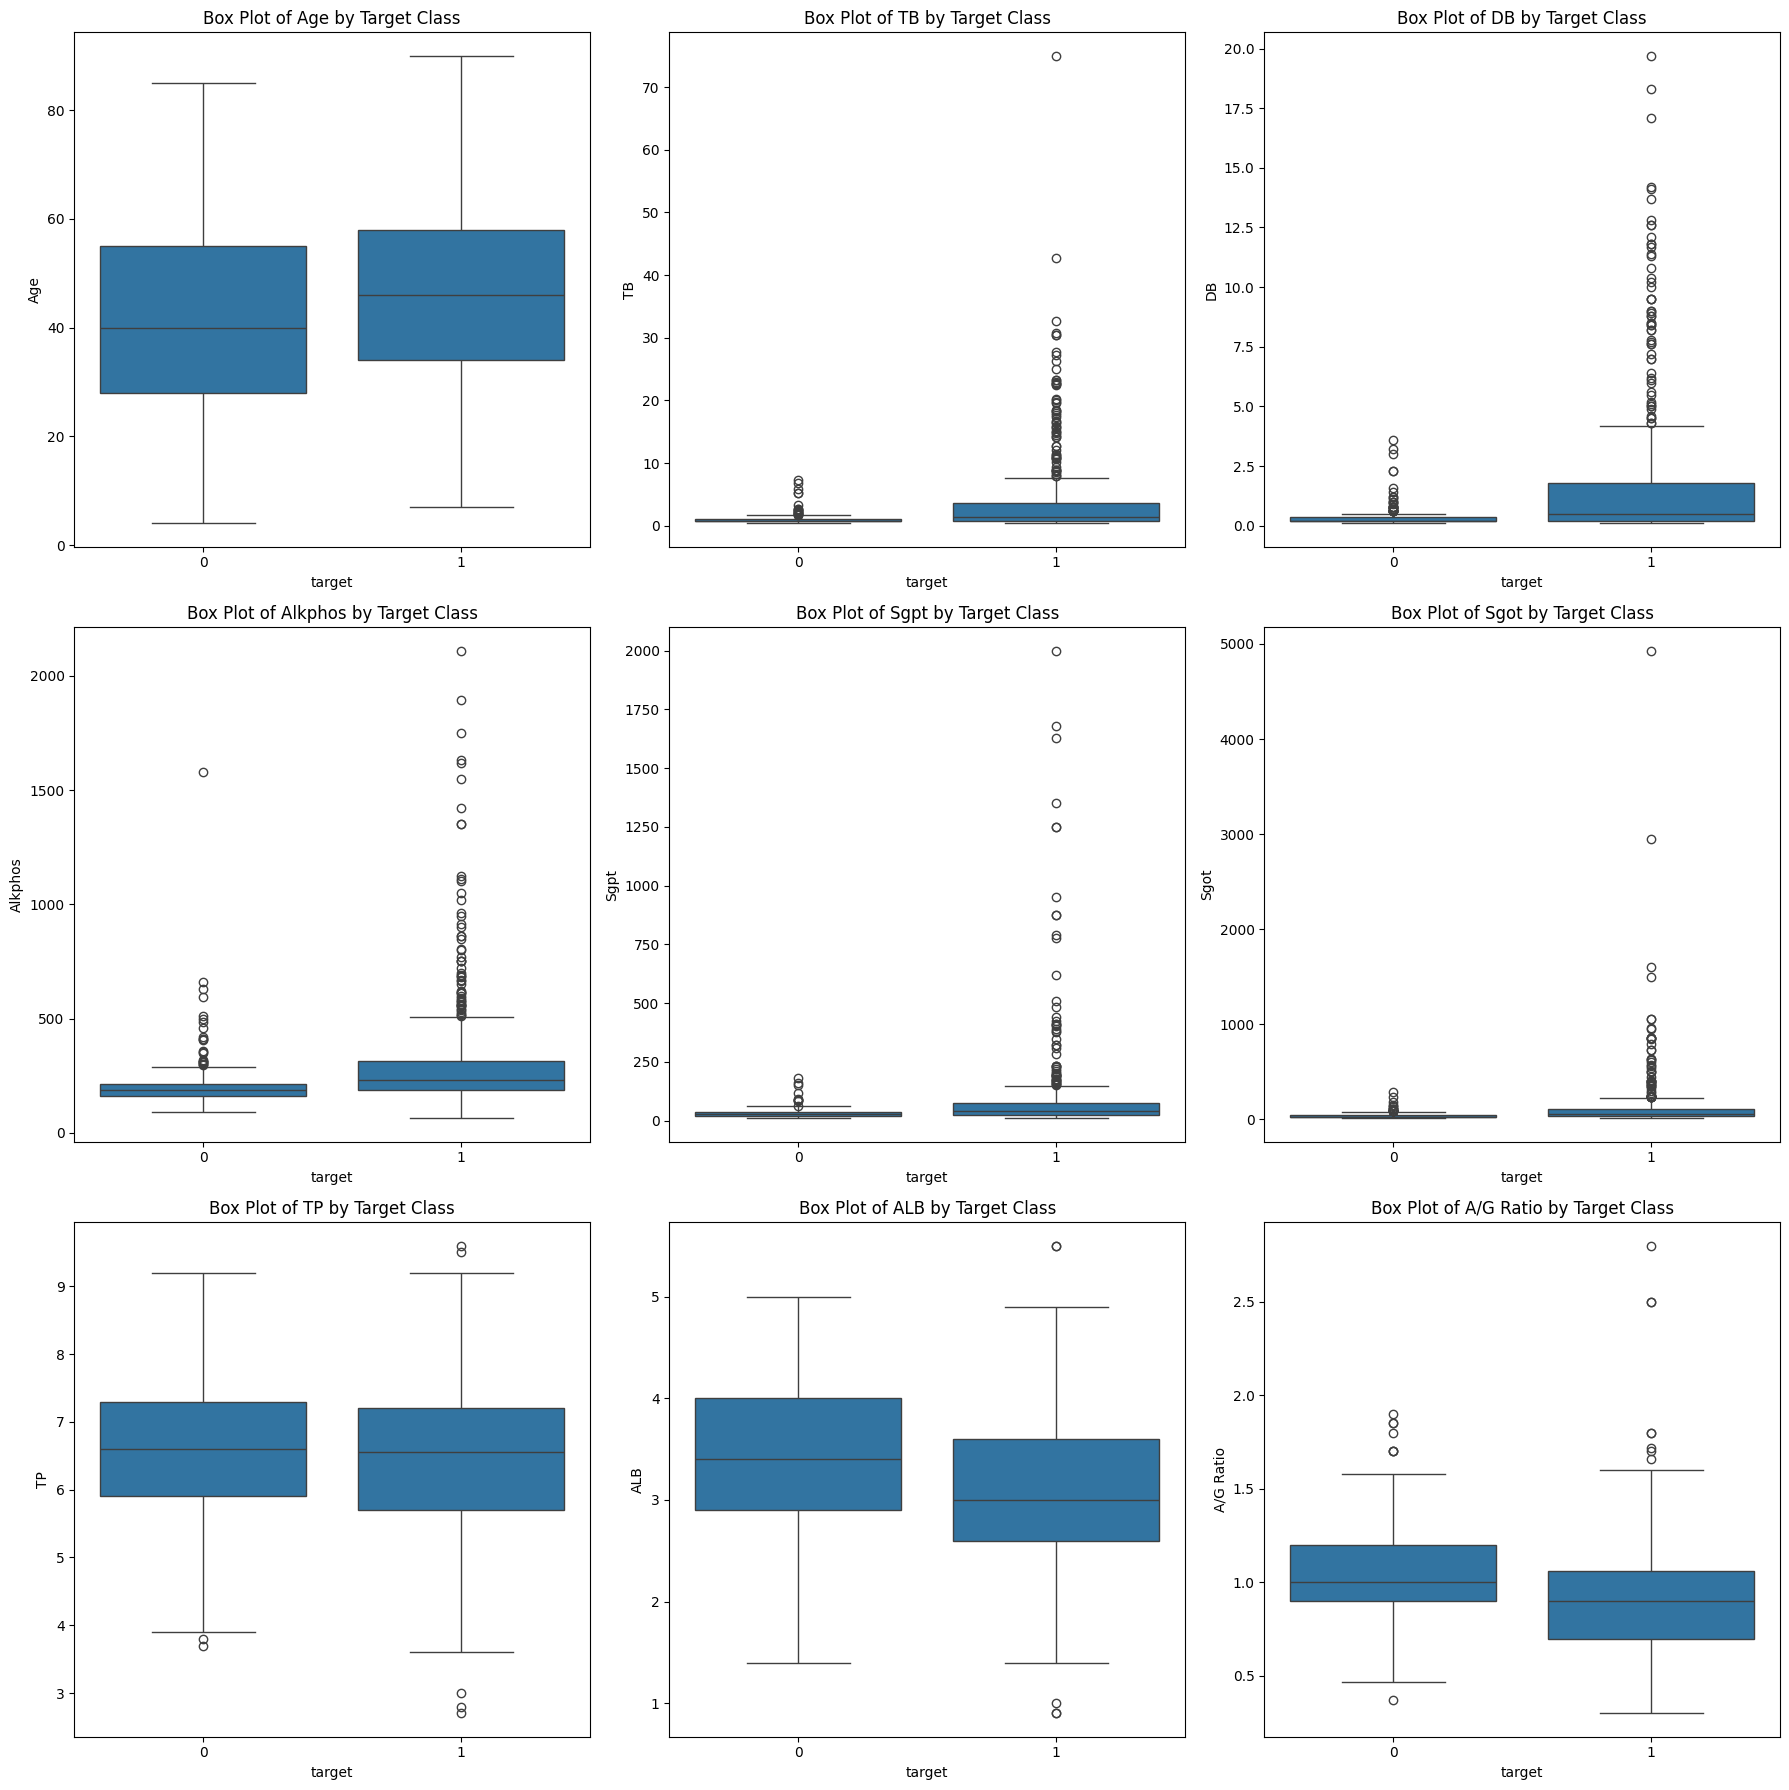

In [13]:
# Let's investigate our Features per disease state
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
# PLotting Gender is not helpful here, so let's remove it and get a count of that data below
data_for_bp = X.drop(columns=['Gender'])

# Plot each feature in a separate subplot
for i, column in enumerate(data_for_bp.columns[:-1]):  # Exclude the target column for individual feature plots
    sns.boxplot(x='target', y=column, data=X, ax=axes[i])
    axes[i].set_title(f'Box Plot of {column} by Target Class')

# Remove any empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Boxplot Summary
Revisiting our Features when grouped by healthy (0) and diseased (1), you can see that as expected, there are a many more outliers in TB, DB, Alkphos, Sgpt, and Sgot than in their healthy counterparts. You can see that the upper extreme or top whisker for the diseased group in the Features mentioned is also noticably greater than in the healthy group. This means that there is more variability for those Features when a person is diseased. 

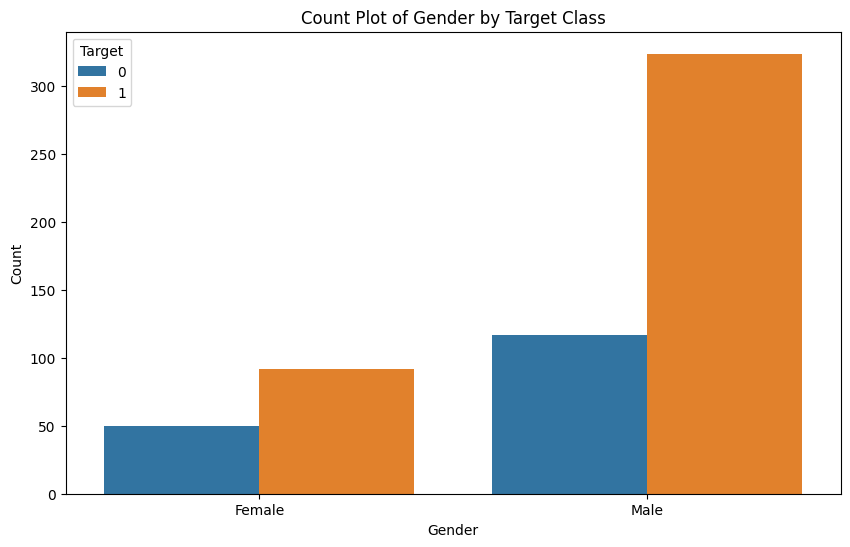

In [14]:
# Count plot for Gender by target class
# Replace 0 and 1 in the 'Gender' column with 'Male' and 'Female' so the graph will be easier to interpret
map_df = X.copy()
gender_mapping_reverse = {0: 'Female', 1: 'Male'}
map_df['Gender'] = map_df['Gender'].map(gender_mapping_reverse)

# Count plot for Gender by target class
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='target', data=map_df)
plt.title('Count Plot of Gender by Target Class')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

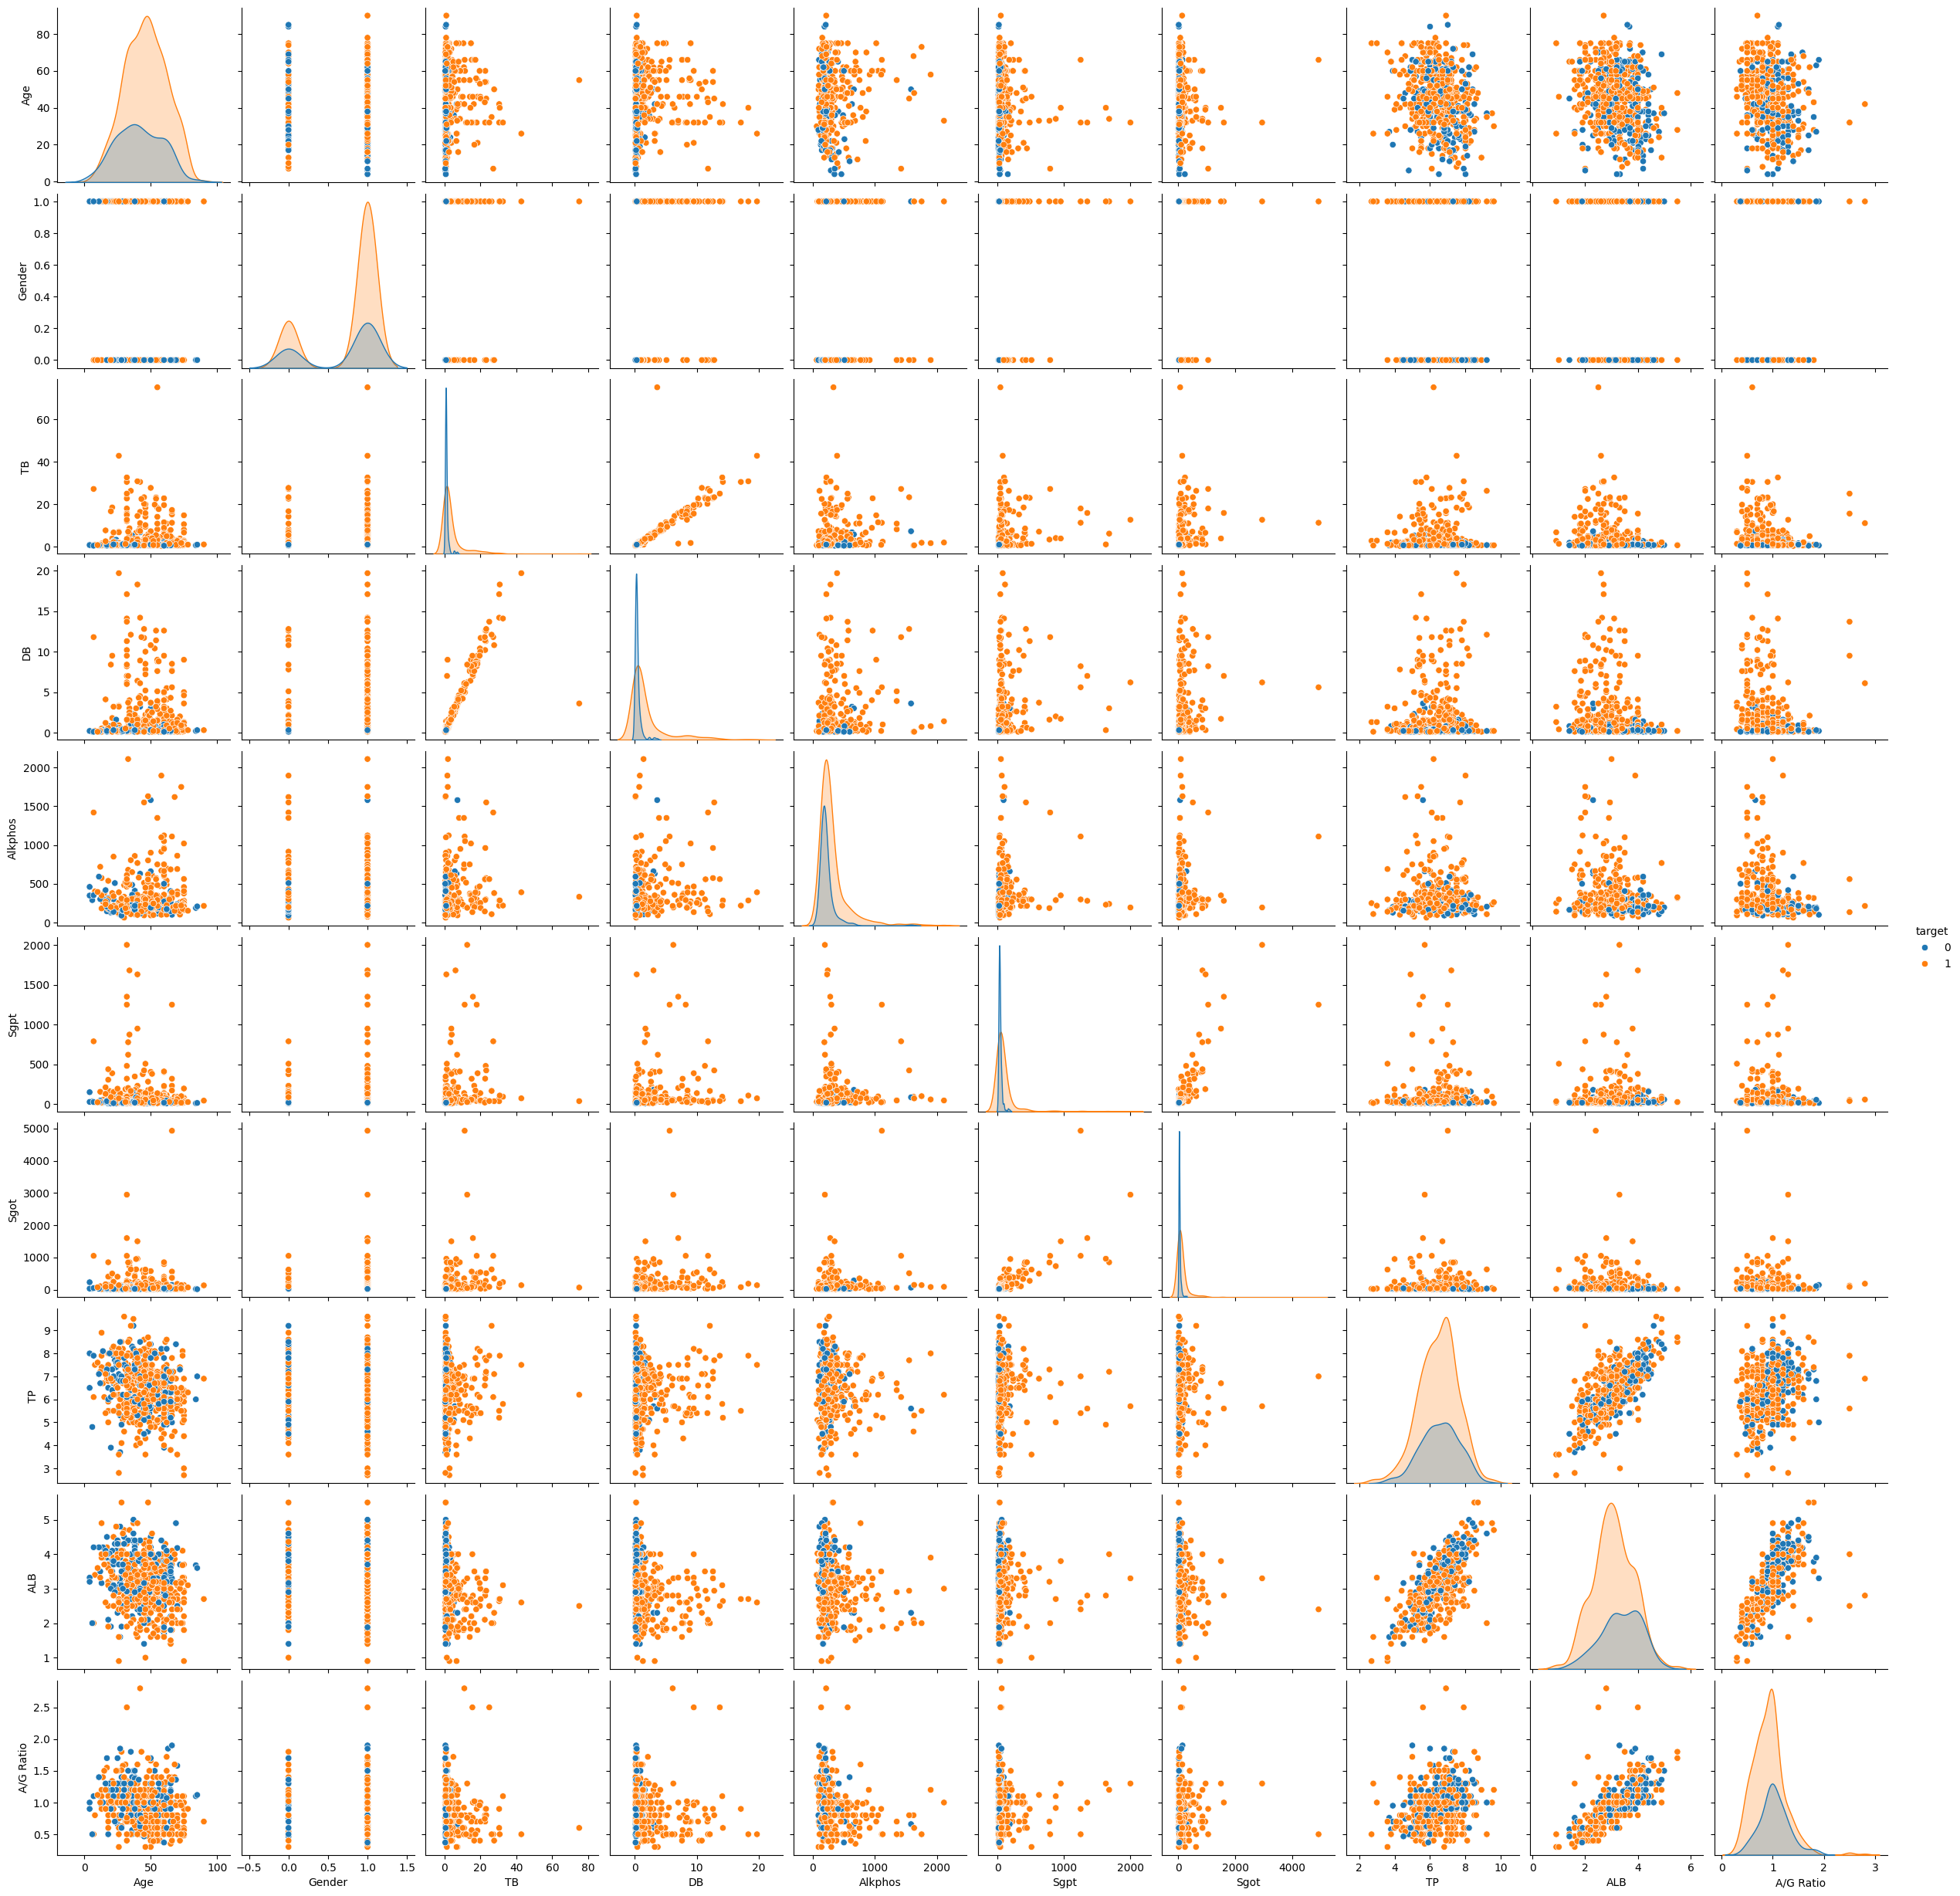

In [15]:
# Let's check out a pair plot for our features
sns.pairplot(X, hue='target', diag_kind='kde')
plt.show()

#### Pair Plot Summary
In these scatter plots we can start to visualize some of thore correlations that we looked at in the correlation matrix above. Notice how TB vs DB almost form an exact line? This let's us know that these features are highly correlated. You can also vizualize those features with light correlation by the shapes that form line-like clusters e.g., ALB vs A/B Ratio. The diagonal of the pair plot shows us a comparison of the distribution of these features given 0, blue, healthy and 1, orange, diseased. What is interesting is in TB, SB, Sgpt, Sgot we see the huge blue spike in the distribution. This could indicate that in healthy folks, these feature is concentrate around the mean of the data and that this feature is almost constant. The orange/disease distribution is more spread out, which indicates variability of these features within the diseased class.

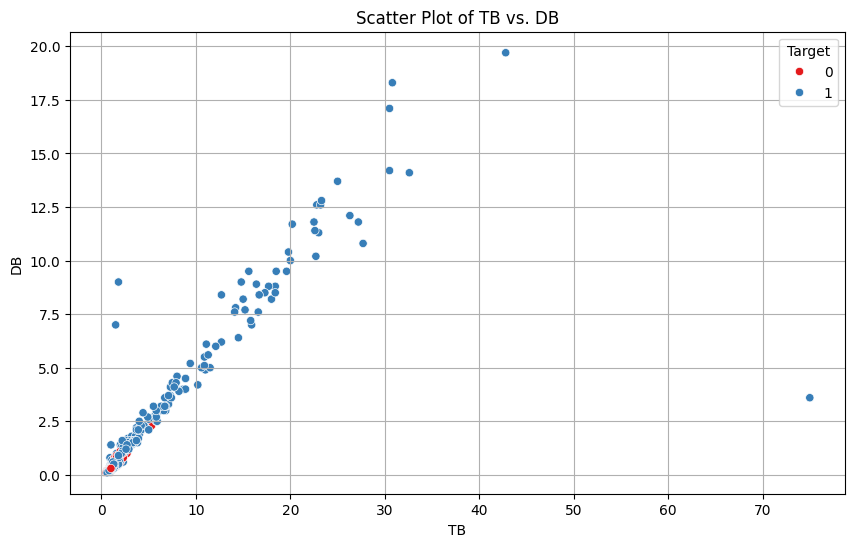

In [16]:
# Scatter plot of TB vs. DB
# Let's see just how linear our TB vs DB gets
tb_vs_tb = X[['TB', 'DB', 'target']]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TB', y='DB', hue='target', palette='Set1', data=tb_vs_tb)
plt.title('Scatter Plot of TB vs. DB')
plt.xlabel('TB')
plt.ylabel('DB')
plt.legend(title='Target')
plt.grid(True)
plt.show()

### EDA Questions:
#### What insights did you gain from the EDA? Are there any features that are strongly correlated with the target variable?
During EDA, I learned tabout which of our features are correlated and that some of the correlations are stronger in the female dataset than the male dataset. This may be due to the fact that we have 3+x more data in the male set, but it could also be an indicator of difference in the features given gender. In terms of correlation to the target variable, there was only a weak correlation (0.1 < abs(x) < 0.3) for TB, DB, Sgot, Sgpt, and Alkphos. These Features also had high correlation with each other, see correlation summary for more information.

#### Provide and interpret at least two visualizations that helped you understand the dataset better.
- Correlation matrix of all features and target
- Boxplots of all features grouped by target
- Scatter plots of all features, including distribution grouped by target.
- (Read summaries of these plots for more info)

### 3. Feature Engineering:
1. Create new features if applicable.
2. Normalize or standardize the data if necessary. - I will generate the base models first so we know if our normalization and/or standardization helps the model then I will apply these methods

TB is Total Bilirubin is the sum of direct (conjugated) and indirect (unconjugated) bilirubin. DB is Direct Bilirubin is a component of total bilirubin. These two measures are inherently correlated since direct bilirubin is a subset of total bilirubin. If one increases, the total will likely increase as well. They provide slightly different information: total bilirubin reflects overall bilirubin metabolism, while direct bilirubin gives insight into conjugation and excretion processes. However, in practice, using both might be redundant if the interest is solely on overall bilirubin levels. Source: [Mayo Clinic](https://www.mayoclinic.org/tests-procedures/bilirubin/about/pac-20393041)

I will combine Db and Tb into Db/Tn Ratio


In [36]:
# Create new features if applicable. 
# I will combine the highly correlated DB and TB into a ratio used in other liver study models.
# Create DB/TB Ratio
X_r = X.copy()
X_r['Db_Tb_Ratio'] = X_r['DB']/X_r['TB']
X_r.drop(columns=['DB'], inplace=True)
X_r.drop(columns=['TB'], inplace=True)

### 4. Model Building:
1. Train at least two different machine learning models (e.g., logistic regression, decision tree, random forest, support vector machine) on the dataset.
2. Use cross-validation to tune hyperparameters and select the best model. Check for this in the Cell where we use grid search cv=5.

In [18]:
# Drop the target from the feature set
X_r.drop(columns=['target'], inplace=True)

In [19]:

# Normalize the features
normalizer = MinMaxScaler()
X_normalized = normalizer.fit_transform(X_r)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Ensure y_train_balanced and y_test are one-dimensional
y_train_balanced = y_train_balanced.values.ravel()
y_test = y_test.values.ravel()

# Initialize a dictionary to store classification reports and AUC values
eval_metrics = {}

# Function to plot AUC ROC Curve
def plot_auc_roc(model_name, y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
eval_metrics['Logistic Regression (base)'] = {
    'classification_report': classification_report(y_test, y_pred_log_reg, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_log_reg)
}

# Logistic Regression with SMOTE
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_balanced, y_train_balanced)
y_pred_log_reg_smote = log_reg_smote.predict(X_test)
y_pred_proba_log_reg_smote = log_reg_smote.predict_proba(X_test)[:, 1]
eval_metrics['Logistic Regression (SMOTE)'] = {
    'classification_report': classification_report(y_test, y_pred_log_reg_smote, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_log_reg_smote)
}

# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_pred_proba_svm = svm.predict_proba(X_test)[:, 1]
eval_metrics['SVM (base)'] = {
    'classification_report': classification_report(y_test, y_pred_svm, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_svm)
}

# SVM with SMOTE
svm_smote = SVC(probability=True)
svm_smote.fit(X_train_balanced, y_train_balanced)
y_pred_svm_smote = svm_smote.predict(X_test)
y_pred_proba_svm_smote = svm_smote.predict_proba(X_test)[:, 1]
eval_metrics['SVM (SMOTE)'] = {
    'classification_report': classification_report(y_test, y_pred_svm_smote, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_svm_smote)
}

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
eval_metrics['Random Forest (base)'] = {
    'classification_report': classification_report(y_test, y_pred_rf, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_rf)
}

# Random Forest with SMOTE
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_balanced, y_train_balanced)
y_pred_rf_smote = rf_smote.predict(X_test)
y_pred_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
eval_metrics['Random Forest (SMOTE)'] = {
    'classification_report': classification_report(y_test, y_pred_rf_smote, output_dict=True),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_rf_smote)
}


C:\Users\shelb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shelb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shelb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shelb\AppData\Local\Programs\Python\Python312\Lib

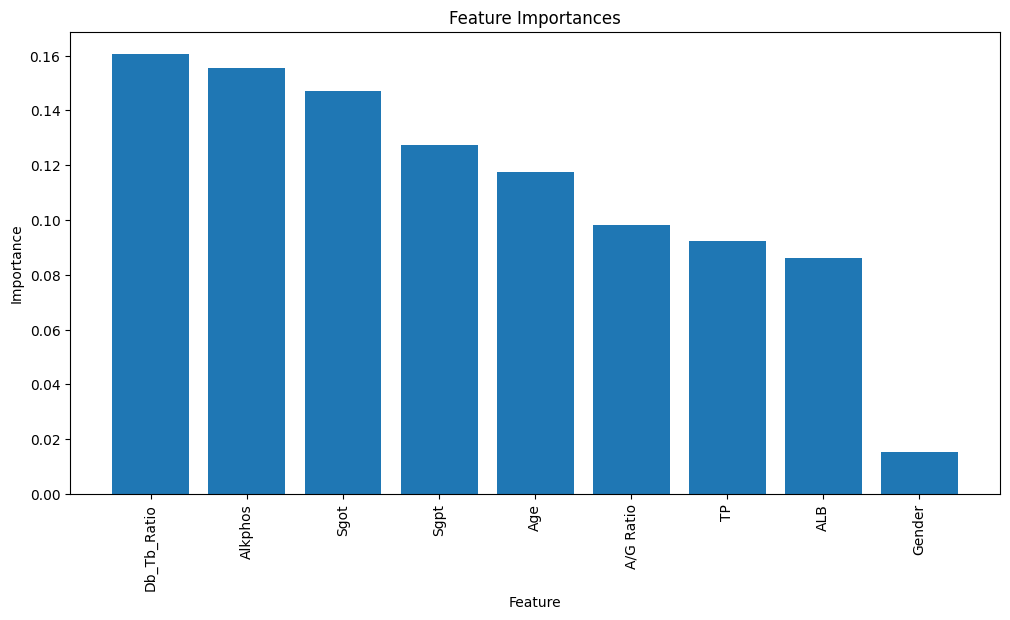

In [20]:
# Let's check Feature Importance in the RF.  
# Feature importance can reveal which factors are most influential in predicting the target variable.
from sklearn.ensemble import RandomForestClassifier

# Get feature importances from the trained model
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_r.shape[1]), importances[indices], align='center')
plt.xticks(range(X_r.shape[1]), X_r.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Our Feature Importance graph shows us that the DB/TB Ratio is the feature that has the most significant impact on our model. This makes sense as there are many studies that show that DB and TB are used as indicators for irregularities in liver function. Although gender is skewed in this dataset with more males than females, it doesn't appear to contribute to the model very much as a feature. 

#### Model Questions:
- Which models did you choose to train and why?
I chose classification models, since we are predicting a categorical outcome (diseased or not.)
1. Random Forest because it is robust to overfitting, handles imbalanced datasets well through ensemble learning, and can provide feature importance insights, which are crucial for understanding the factors influencing disease detection.
2. Support Vector Machine (SVM) because it is effective in high-dimensional spaces and can handle imbalanced datasets by adjusting class weights, making it suitable for distinguishing between diseased and non-diseased cases with precision.
3. Logistic Regression because it provides a straightforward probabilistic interpretation of disease likelihood, is easy to implement and interpret, and can handle class imbalance by using techniques such as class weighting or resampling (in our case we used SMOTE.)

I also attempted to create models based on Gender, but was not confident that the model for females would perform well on "real" data due to small sample size. Additionally, as you will see later in the notebook, Gender is the lowest contributing feature in our feature importance graph, so we shouldn't put too much stock into its contribution to our model. 

- How did you select and tune the hyperparameters for these models?
1. Random Forest: I selected and tuned the hyperparameters for the Random Forest model using GridSearchCV, exploring a range of values for the number of trees, maximum depth, and minimum samples required for splitting nodes to optimize the model's performance in detecting disease in the imbalanced dataset.

2. SVM: I tuned the hyperparameters for the SVM model by leveraging GridSearchCV to find the optimal combinations of the regularization parameter (C) and kernel coefficient (gamma), which helped improve the model's ability to accurately classify diseased and non-diseased cases despite the class imbalance.

3. Logistic Regression: For Logistic Regression, I employed GridSearchCV to select the best hyperparameters by adjusting the regularization strength (C) and solver methods, ensuring the model achieved the best balance between sensitivity and specificity for detecting disease in the imbalanced dataset.

### 5. Model Evaluation:

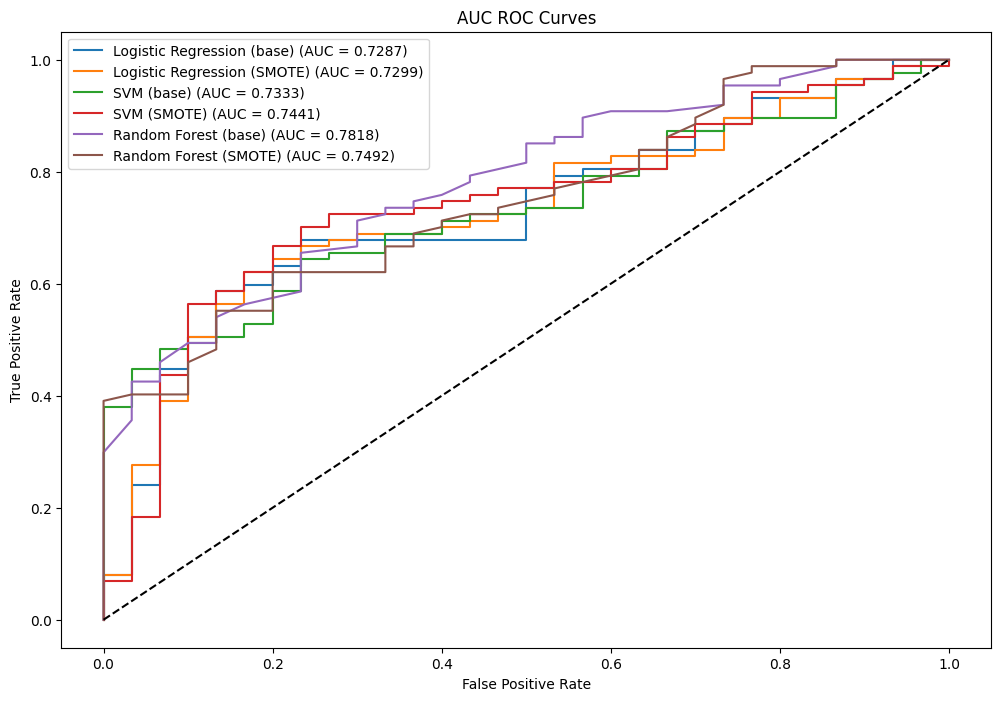

In [21]:
# 
# Plot the AUC ROC curves
plt.figure(figsize=(12, 8))
plot_auc_roc('Logistic Regression (base)', y_test, y_pred_proba_log_reg)
plot_auc_roc('Logistic Regression (SMOTE)', y_test, y_pred_proba_log_reg_smote)
plot_auc_roc('SVM (base)', y_test, y_pred_proba_svm)
plot_auc_roc('SVM (SMOTE)', y_test, y_pred_proba_svm_smote)
plot_auc_roc('Random Forest (base)', y_test, y_pred_proba_rf)
plot_auc_roc('Random Forest (SMOTE)', y_test, y_pred_proba_rf_smote)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC ROC Curves')
plt.legend()
plt.show()

#### Understand AUC ROC Curves for our models
- AUC = 0.5: The model has no discrimination capability, similar to random guessing.
- AUC < 0.5: The model is worse than random guessing.
- AUC = 1.0: The model has perfect discrimination capability, correctly classifying all positive and negative cases.

We can see that our Random Forest model performs the best even when we use SMOTE to help with the class imbalance. Let's check our classification reports and see how the performance breaks down based on the target variable.

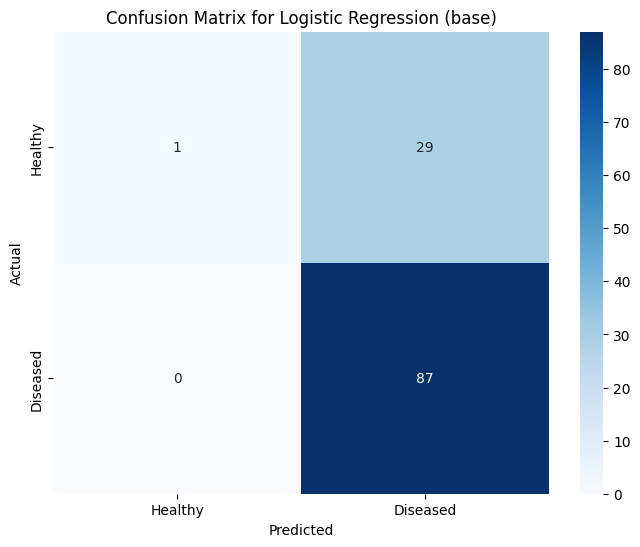

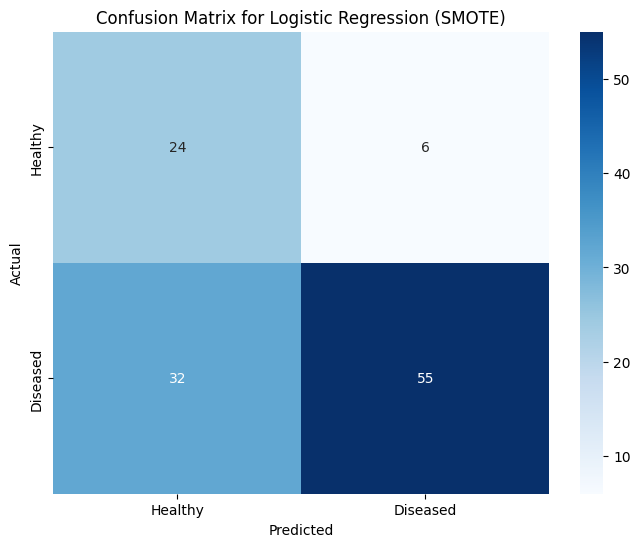

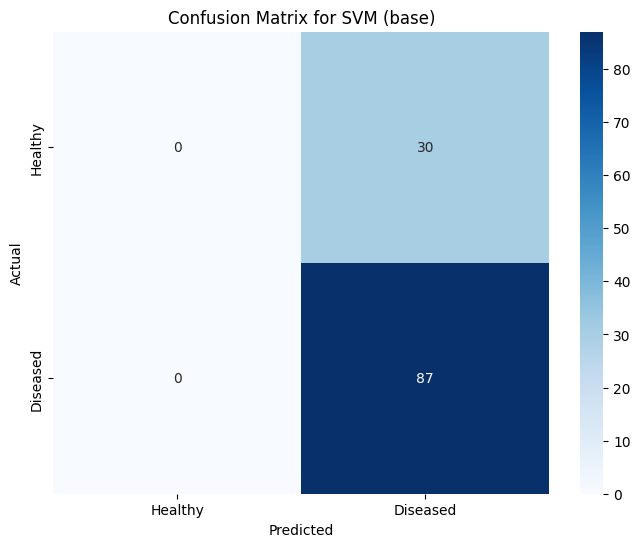

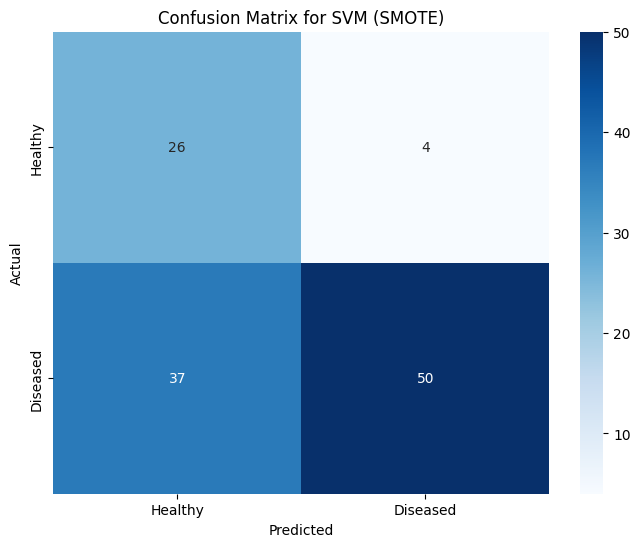

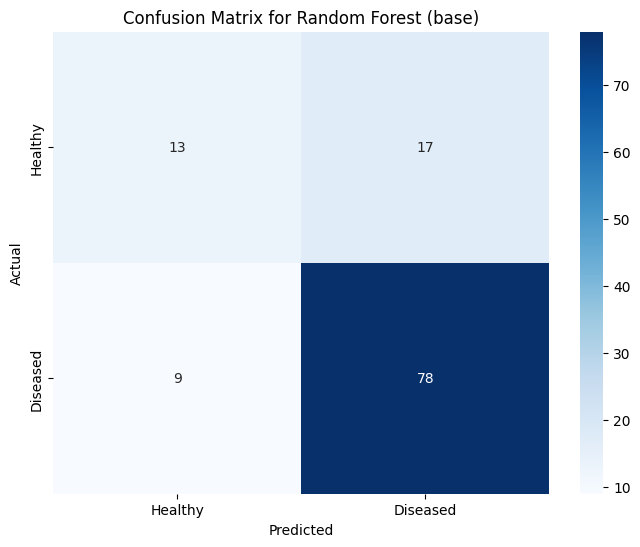

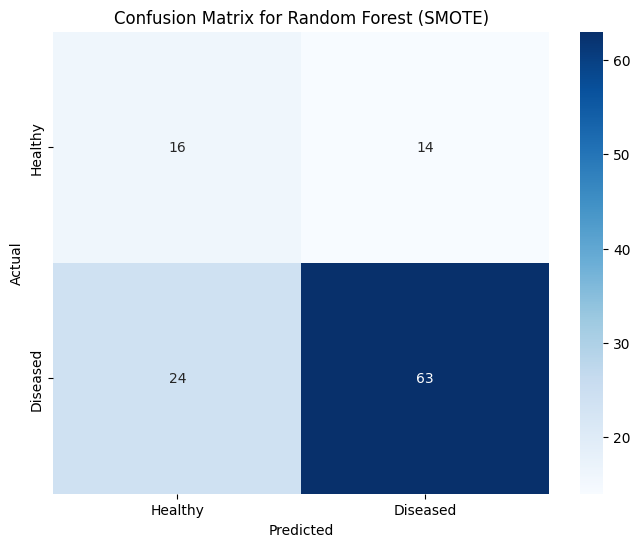

In [22]:
# I am interested in False Negatives for each model since in this case a false negative is someone who is sick 
# that our model incorrectly says is healthy. In this case, a false negative could mean death for this person.
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diseased'], yticklabels=['Healthy', 'Diseased'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Logistic Regression (base)
cm_lr = confusion_matrix(y_test, y_pred_log_reg)
plot_confusion_matrix(cm_lr, 'Logistic Regression (base)')

# Logistic Regression (SMOTE)
cm_lr_smote = confusion_matrix(y_test, y_pred_log_reg_smote)
plot_confusion_matrix(cm_lr_smote, 'Logistic Regression (SMOTE)')

# SVM (base)
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, 'SVM (base)')

# SVM (SMOTE)
cm_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)
plot_confusion_matrix(cm_svm_smote, 'SVM (SMOTE)')

# Random Forest (base)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, 'Random Forest (base)')

# Random Forest (SMOTE)
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plot_confusion_matrix(cm_rf_smote, 'Random Forest (SMOTE)')

#### Confusion Matrix Summary
SVM and Logistic Regression base did not classify any of the people as healthy when they are sick, however, they did misclassify 30 and 29 people as sick who were healthy. The LR base misclassified a total of 29 records with a bias towards healthy as diseased. The Random Forest (base) only misclassified 12 folks as healthy who were sick and 20 who were healthy as sick. Because we are working with health records, we want to reduce the number of false positives and especially false negatives. 

In [23]:
# Print the classification reports
for model_name, metrics in eval_metrics.items():
    print(f"{model_name} Classification Report:\n", "healthy: ", metrics['classification_report']['0'], "\n", "diseased: ", metrics['classification_report']['1'], "\n")
    print(f"{model_name} AUC ROC: {metrics['auc_roc']:.4f}\n")

Logistic Regression (base) Classification Report:
 healthy:  {'precision': 1.0, 'recall': 0.03333333333333333, 'f1-score': 0.06451612903225806, 'support': 30.0} 
 diseased:  {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 87.0} 

Logistic Regression (base) AUC ROC: 0.7287

Logistic Regression (SMOTE) Classification Report:
 healthy:  {'precision': 0.42857142857142855, 'recall': 0.8, 'f1-score': 0.5581395348837209, 'support': 30.0} 
 diseased:  {'precision': 0.9016393442622951, 'recall': 0.632183908045977, 'f1-score': 0.7432432432432432, 'support': 87.0} 

Logistic Regression (SMOTE) AUC ROC: 0.7299

SVM (base) Classification Report:
 healthy:  {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30.0} 
 diseased:  {'precision': 0.7435897435897436, 'recall': 1.0, 'f1-score': 0.8529411764705882, 'support': 87.0} 

SVM (base) AUC ROC: 0.7333

SVM (SMOTE) Classification Report:
 healthy:  {'precision': 0.4126984126984127, 'recall': 0.8666666666666667,

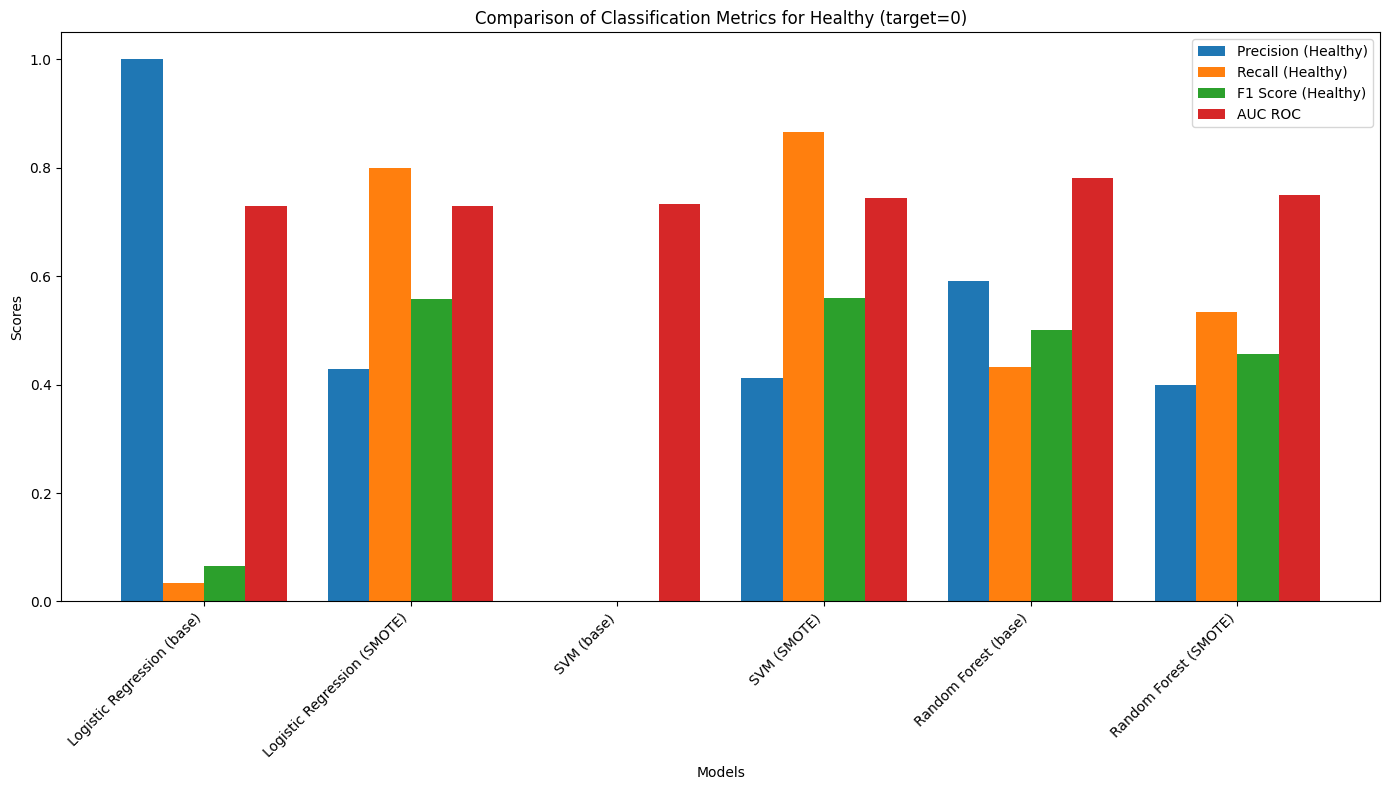

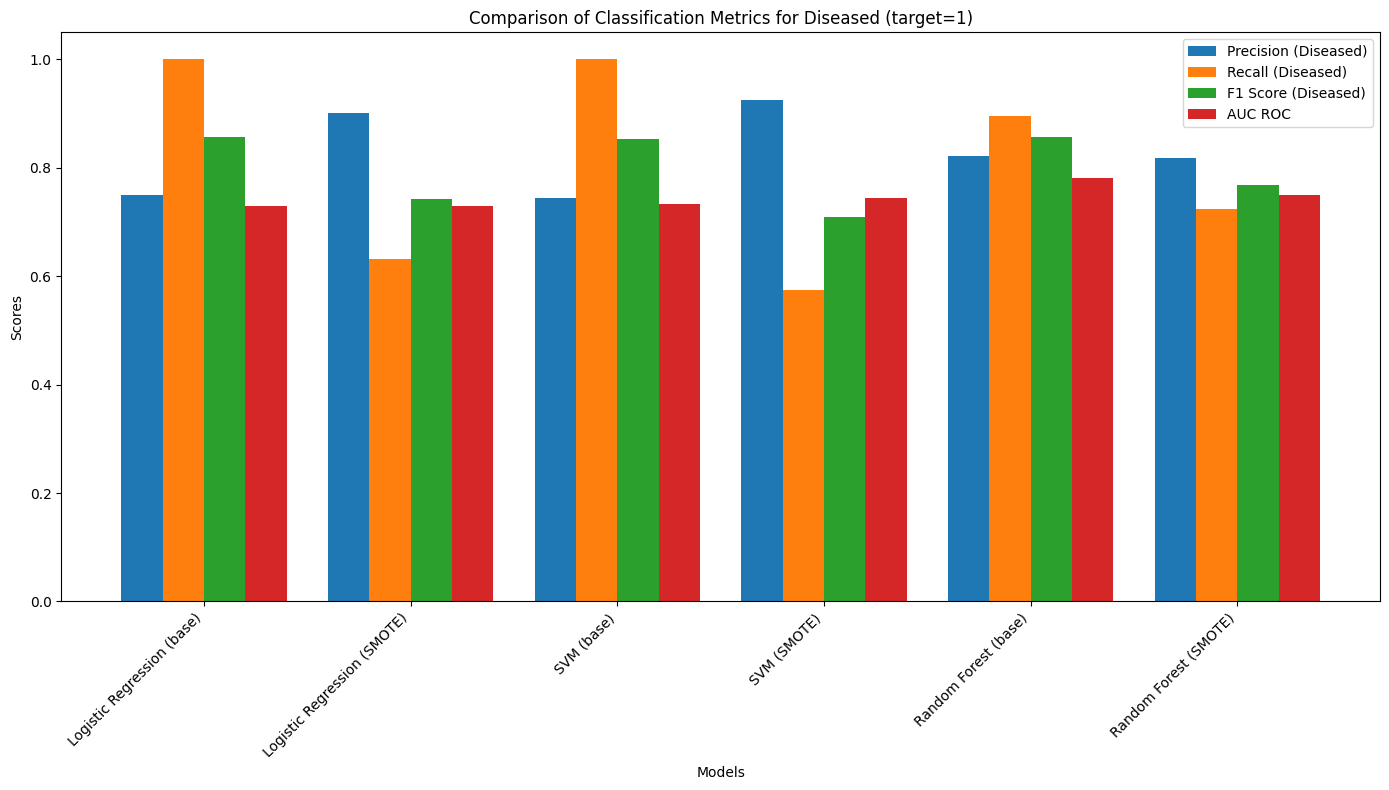

In [24]:
# Extracting metrics for the graph comparison
models = []
precisions_healthy = []
recalls_healthy = []
f1_scores_healthy = []
precisions_diseased = []
recalls_diseased = []
f1_scores_diseased = []
auc_rocs = []

for model_name, metrics in eval_metrics.items():
    report = metrics['classification_report']
    models.append(model_name)
    precisions_healthy.append(report['0']['precision'])
    recalls_healthy.append(report['0']['recall'])
    f1_scores_healthy.append(report['0']['f1-score'])
    precisions_diseased.append(report['1']['precision'])
    recalls_diseased.append(report['1']['recall'])
    f1_scores_diseased.append(report['1']['f1-score'])
    auc_rocs.append(metrics['auc_roc'])

# Plotting the comparison of classification metrics for Healthy (target=0)
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(14, 8))
plt.bar(x - 1.5*width, precisions_healthy, width, label='Precision (Healthy)')
plt.bar(x - 0.5*width, recalls_healthy, width, label='Recall (Healthy)')
plt.bar(x + 0.5*width, f1_scores_healthy, width, label='F1 Score (Healthy)')
plt.bar(x + 1.5*width, auc_rocs, width, label='AUC ROC')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Classification Metrics for Healthy (target=0)')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the comparison of classification metrics for Diseased (target=1)
plt.figure(figsize=(14, 8))
plt.bar(x - 1.5*width, precisions_diseased, width, label='Precision (Diseased)')
plt.bar(x - 0.5*width, recalls_diseased, width, label='Recall (Diseased)')
plt.bar(x + 0.5*width, f1_scores_diseased, width, label='F1 Score (Diseased)')
plt.bar(x + 1.5*width, auc_rocs, width, label='AUC ROC')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Classification Metrics for Diseased (target=1)')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

#### What the classification report tells us
2. Compare the performance of different models and discuss which one is better suited for this dataset and why.

Notice the precision, recall, and F1-score for the 0 (healthy) row in the SVM and the logistic regression models.
LR Model (Base Model):

        precision    recall  f1-score   support

    0       1.00      0.03      0.06        30

This tells us that of the 30 records that should be labeled healthy, the model is identifying only 3% of the actual positive cases. This indicates a very low true positive rate. The 1.00 precision would be great if the recall and F1-Score were higher. 1.00 here means the one call we did make correctly, we got right. Not a good indication of the model's performance. We can also see the model biased heavily to the diseased state.

SVM (base model):

        precision    recall  f1-score   support
    
    0       0.00      0.00      0.00        30

The SVM shows us what would happen if a model simply lumped every record into the diseased state. The SMOTE improved the accuracy in the minority class here at the expense of the overall performance of the model. However, introducing SMOTE will likely improve how our model would do on "real world" data outside of this set as in reality, most folks do not have cirrhosis. 

#### What metrics did you use to evaluate the models, and why are these metrics appropriate for this task?
- Metrics Used for Evaluation
- Precision
- Recall
- F1-Score
- AUC ROC
1. Precision
Precision is crucial when the cost of false positives is high. In the context of a medical dataset, precision helps understand how many of the predicted positive cases are actual positive cases. High precision means fewer false positives, which is important to ensure that non-diseased individuals are not incorrectly diagnosed as diseased.

2. Recall (Sensitivity)
Recall is vital when the cost of false negatives is high. In a medical setting, missing a positive case (false negative) can have serious consequences. High recall means fewer false negatives, ensuring that most positive cases are identified.

3. F1-Score
The F1-score balances precision and recall, providing a single metric that considers both false positives and false negatives. This is particularly useful for imbalanced datasets, where both precision and recall are important. It provides a better measure of a model's performance when there is an uneven class distribution.

4. AUC ROC (Area Under the Receiver Operating Characteristic Curve)
AUC ROC provides an aggregate measure of performance across all classification thresholds. It is a robust metric for evaluating the performance of a model in distinguishing between classes. Higher AUC values indicate better overall model performance. 

Note: I did not use accuracy here, High accuracy in imbalanced datasets does not necessarily indicate a good model. It can give a false sense of performance because it does not consider the distribution of the classes and the importance of detecting the minority class. In our case the healthy target and the gender=female feature are both minority classes,

Summary
In summary, precision, recall, F1-score, and AUC ROC are more appropriate metrics for evaluating models on imbalanced datasets, especially in medical contexts. 

#### Which model is the best
Criteria for Evaluation
- AUC ROC: Measures the ability of the model to distinguish between the positive and negative classes. Higher values are better.
- Recall (1): Important for medical datasets to ensure positive cases are not missed.
- F1-Score (1): Balances precision and recall for the positive class.

Best Model: Random Forest (base)
- AUC ROC: 0.7818 (Highest among all models)
- Recall (1): 0.897 (Second highest, only behind Logistic Regression base.) It maintains a high recall for the positive class, which is crucial for medical datasets to avoid missing positive cases.
- F1-Score (1): 0.857 (Same as Logistic Regression base but higher than other models.) It has a high F1-score for the positive class, balancing precision and recall effectively.

In [25]:
# Let's try creating models for females and males.
# Ensure y_train_balanced and y_test are one-dimensional
X_r['target'] = y['Selector']
# Separate the data by Gender
X_male = X_r[X_r['Gender'] == 1]
y_male = X_male[['target']]
X_male.drop(columns=['target'], inplace=True)

X_female = X_r[X_r['Gender'] == 0]
y_female = X_female[['target']]
X_female.drop(columns=['target'], inplace=True)


# Split the data into training and test sets
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(X_male, y_male, test_size=0.2, random_state=42)
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(X_female, y_female, test_size=0.2, random_state=42)

X_train_male, y_train_male = smote.fit_resample(X_train_male, y_train_male)
X_train_female, y_train_female = smote.fit_resample(X_train_female, y_train_female)

# # Ensure y_train_balanced and y_test are one-dimensional
y_train_female = y_train_female.values.ravel()
y_test_female = y_test_female.values.ravel()

y_train_male = y_train_male.values.ravel()
y_test_male = y_test_male.values.ravel()

# Train separate models 
# RF
clf_male = RandomForestClassifier(random_state=42)
clf_male.fit(X_train_male, y_train_male)

clf_female = RandomForestClassifier(random_state=42)
clf_female.fit(X_train_female, y_train_female)

# SVM
svm_male = SVC()
svm_male.fit(X_train_male, y_train_male)

svm_female = SVC()
svm_female.fit(X_train_female, y_train_female)

#Logistic Regression
log_reg_male = LogisticRegression(max_iter=1000)
log_reg_male.fit(X_train_male, y_train_male)

log_reg_female = LogisticRegression(max_iter=1000)
log_reg_female.fit(X_train_female, y_train_female)

# Make predictions RF
y_pred_male_rf = clf_male.predict(X_test_male)
y_pred_female_rf = clf_female.predict(X_test_female)

# Make predictions SVM
y_pred_male_svm = svm_male.predict(X_test_male)
y_pred_female_svm = svm_female.predict(X_test_female)

# Make Predictions LR
y_pred_male_lr = log_reg_male.predict(X_test_male)
y_pred_female_lr = log_reg_female.predict(X_test_female)

# Evaluate the models
print("Random Forest Classification Report for Male Model:\n", classification_report(y_test_male, y_pred_male_rf))
print("Random Forest Classification Report for Female Model:\n", classification_report(y_test_female, y_pred_female_rf))

print("SVM Classification Report for Male Model:\n", classification_report(y_test_male, y_pred_male_svm))
print("SVM Classification Report for Female Model:\n", classification_report(y_test_female, y_pred_female_svm))

print("LR Classification Report for Male Model:\n", classification_report(y_test_male, y_pred_male_lr))
print("LR Classification Report for Female Model:\n", classification_report(y_test_female, y_pred_female_lr))

C:\Users\shelb\AppData\Local\Temp\ipykernel_12204\2762283102.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_male.drop(columns=['target'], inplace=True)
C:\Users\shelb\AppData\Local\Temp\ipykernel_12204\2762283102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_female.drop(columns=['target'], inplace=True)


Random Forest Classification Report for Male Model:
               precision    recall  f1-score   support

           0       0.59      0.64      0.62        25
           1       0.85      0.83      0.84        64

    accuracy                           0.78        89
   macro avg       0.72      0.73      0.73        89
weighted avg       0.78      0.78      0.78        89

Random Forest Classification Report for Female Model:
               precision    recall  f1-score   support

           0       0.30      0.30      0.30        10
           1       0.63      0.63      0.63        19

    accuracy                           0.52        29
   macro avg       0.47      0.47      0.47        29
weighted avg       0.52      0.52      0.52        29

SVM Classification Report for Male Model:
               precision    recall  f1-score   support

           0       0.44      0.84      0.58        25
           1       0.90      0.58      0.70        64

    accuracy                   

#### Male vs. Female Model Interpretation
Although we are getting slightly better performance in the male models, I would not recommend using female models since the test size is only 29, which is not enough samples to be confident in our model's outcomes. Additionally, we outlined that gender has the lowest feature importance. Let's continue with our combined model and see if hypertuning our parameters can improve our performance

#### Model Questions:
- Which models did you choose to train and why?
I chose classification models, since we are predicting a categorical outcome (diseased or not.)
1. Random Forest because it is robust to overfitting, handles imbalanced datasets well through ensemble learning, and can provide feature importance insights, which are crucial for understanding the factors influencing disease detection.
2. Support Vector Machine (SVM) because it is effective in high-dimensional spaces and can handle imbalanced datasets by adjusting class weights, making it suitable for distinguishing between diseased and non-diseased cases with precision.
3. Logistic Regression because it provides a straightforward probabilistic interpretation of disease likelihood, is easy to implement and interpret, and can handle class imbalance by using techniques such as class weighting or resampling (in our case we used SMOTE.)

I also attempted to create models based on Gender, but was not confident that the model for females would perform well on "real" data due to small sample size.

- How did you select and tune the hyperparameters for these models?
1. Random Forest: I selected and tuned the hyperparameters for the Random Forest model using GridSearchCV, exploring a range of values for the number of trees, maximum depth, and minimum samples required for splitting nodes to optimize the model's performance in detecting disease in the imbalanced dataset.

2. SVM: I tuned the hyperparameters for the SVM model by leveraging GridSearchCV to find the optimal combinations of the regularization parameter (C) and kernel coefficient (gamma), which helped improve the model's ability to accurately classify diseased and non-diseased cases despite the class imbalance.

3. Logistic Regression: For Logistic Regression, I employed GridSearchCV to select the best hyperparameters by adjusting the regularization strength (C) and solver methods, ensuring the model achieved the best balance between sensitivity and specificity for detecting disease in the imbalanced dataset.

In [26]:
# These accuracies aren't too bad, but let's do some hyper parameter tuning and see if we can improve our models. 
# We will use grid search. First let's make the grids

# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 250],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV with StratifiedKFold cross-validation. 
# We also want to score based on F1 and we will not use the "SMOTE"ed data since our random forest performed better on the non-SMOTE and we learned that
# Gender does not contribute much to the model

# cv = 5 is where we use cross-validation for hypertuning, we will cross validate our final model as well further in the NB
# Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train, y_train.values.ravel())

# SVM
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='f1')
grid_search_svm.fit(X_train, y_train.values.ravel())

# Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 250]},
             scoring='f1')

In [27]:
# Best hyperparameters
best_params_lr = grid_search_lr.best_params_
best_params_svm = grid_search_svm.best_params_
best_params_rf = grid_search_rf.best_params_

print(f"Best hyperparameters for Logistic Regression: {best_params_lr}")
print(f"Best hyperparameters for SVM: {best_params_svm}")
print(f"Best hyperparameters for Random Forest: {best_params_rf}\n\n")

# Evaluate the best models on the test set
best_model_lr = grid_search_lr.best_estimator_
best_model_svm = grid_search_svm.best_estimator_
best_model_rf = grid_search_rf.best_estimator_

y_pred_lr = best_model_lr.predict(X_test)
y_pred_svm = best_model_svm.predict(X_test)
y_pred_rf = best_model_rf.predict(X_test)

# Calculate probabilities for AUC ROC
y_pred_proba_lr = best_model_lr.predict_proba(X_test)[:, 1]
y_pred_proba_svm = best_model_svm.decision_function(X_test)  # SVM decision function
y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

# Calculate F1 scores
test_f1_lr = f1_score(y_test, y_pred_lr)
test_f1_svm = f1_score(y_test, y_pred_svm)
test_f1_rf = f1_score(y_test, y_pred_rf)

# Calculate precision
test_precision_lr = precision_score(y_test, y_pred_lr)
test_precision_svm = precision_score(y_test, y_pred_svm)
test_precision_rf = precision_score(y_test, y_pred_rf)

# Calculate recall
test_recall_lr = recall_score(y_test, y_pred_lr)
test_recall_svm = recall_score(y_test, y_pred_svm)
test_recall_rf = recall_score(y_test, y_pred_rf)

# Calculate AUC ROC
test_auc_roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
test_auc_roc_svm = roc_auc_score(y_test, y_pred_proba_svm)
test_auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Logistic Regression test F1 score with best hyperparameters: {test_f1_lr:.4f}")
print(f"Logistic Regression test precision with best hyperparameters: {test_precision_lr:.4f}")
print(f"Logistic Regression test recall with best hyperparameters: {test_recall_lr:.4f}")
print(f"Logistic Regression test AUC ROC with best hyperparameters: {test_auc_roc_lr:.4f}\n\n")

print(f"SVM test F1 score with best hyperparameters: {test_f1_svm:.4f}")
print(f"SVM test precision with best hyperparameters: {test_precision_svm:.4f}")
print(f"SVM test recall with best hyperparameters: {test_recall_svm:.4f}")
print(f"SVM test AUC ROC with best hyperparameters: {test_auc_roc_svm:.4f}\n\n")

print(f"Random Forest test F1 score with best hyperparameters: {test_f1_rf:.4f}")
print(f"Random Forest test precision with best hyperparameters: {test_precision_rf:.4f}")
print(f"Random Forest test recall with best hyperparameters: {test_recall_rf:.4f}")
print(f"Random Forest test AUC ROC with best hyperparameters: {test_auc_roc_rf:.4f}\n\n")

Best hyperparameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best hyperparameters for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best hyperparameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


Logistic Regression test F1 score with best hyperparameters: 0.8571
Logistic Regression test precision with best hyperparameters: 0.7500
Logistic Regression test recall with best hyperparameters: 1.0000
Logistic Regression test AUC ROC with best hyperparameters: 0.7264


SVM test F1 score with best hyperparameters: 0.8529
SVM test precision with best hyperparameters: 0.7436
SVM test recall with best hyperparameters: 1.0000
SVM test AUC ROC with best hyperparameters: 0.7015


Random Forest test F1 score with best hyperparameters: 0.8352
Random Forest test precision with best hyperparameters: 0.8000
Random Forest test recall with best hyperparameters: 0.8736
Random Fore

#### Post hypertuning evaluation
The Random Forest model is the best overall model based on the evaluation metrics provided. Here are the reasons:

1. Highest AUC ROC: It has the highest AUC ROC (0.7889), indicating the best overall discriminatory ability.
2. Highest Precision: It has the highest precision (0.7895), meaning it produces fewer false positives, which is important for avoiding unnecessary treatment for healthy individuals.
3. Balanced Performance: It offers a good balance between recall and precision, with a reasonably high recall (0.8621) and the highest precision among the models, leading to a robust and reliable performance in a medical context.

Our final model will be a Random Forest with these hyperparameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

## The final model!
### Random Forest with these hyperparameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

C:\Users\shelb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Final Random Forest Model Evaluation:
F1 Score: 0.8432
Precision: 0.7959
Recall: 0.8966
AUC ROC: 0.8000


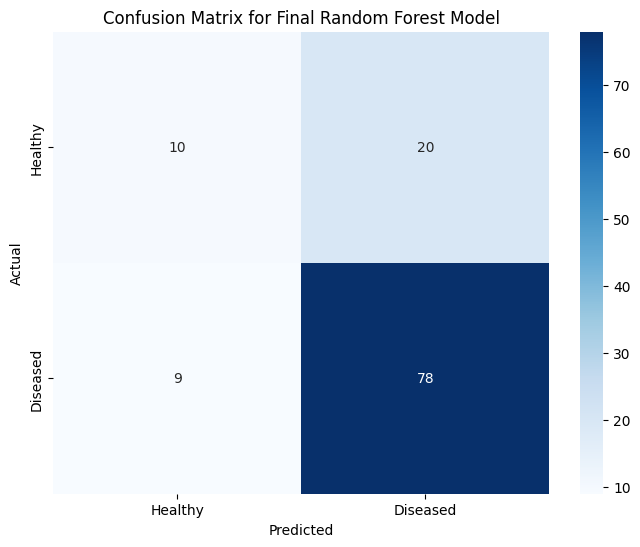

In [28]:
# Optimized hyperparameters for Random Forest
optimized_params_rf = {
    'bootstrap': True,
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Build the final Random Forest model
final_rf_model = RandomForestClassifier(**optimized_params_rf, random_state=42)

# Train the final model on the original training set without SMOTE
final_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_final_rf = final_rf_model.predict(X_test)
y_pred_proba_final_rf = final_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the final model
final_rf_f1 = f1_score(y_test, y_pred_final_rf)
final_rf_precision = precision_score(y_test, y_pred_final_rf)
final_rf_recall = recall_score(y_test, y_pred_final_rf)
final_rf_auc_roc = roc_auc_score(y_test, y_pred_proba_final_rf)

print("Final Random Forest Model Evaluation:")
print(f"F1 Score: {final_rf_f1:.4f}")
print(f"Precision: {final_rf_precision:.4f}")
print(f"Recall: {final_rf_recall:.4f}")
print(f"AUC ROC: {final_rf_auc_roc:.4f}")

# Confusion Matrix
cm_final_rf = confusion_matrix(y_test, y_pred_final_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diseased'], yticklabels=['Healthy', 'Diseased'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Final Random Forest Model')
plt.show()

In [37]:
# Let's look at those records that are close to the decision boundary for our model (0.40 <= x < 0.50.) 
# This indicates that the model is almost equally uncertain about whether this individual is healthy or diseased.
# Therefore, I would reassign these folks to 1 (diseased) regardless of predicted value to be sure that those folks 
# whose records fall close to the decision boundary on the healthy side get screened for cirrhosis
# as they may have pre-cirrhosis.

# Function to print predictions with probabilities and include features
def print_predictions_with_probabilities(model_name, X_test, y_test, y_pred, y_pred_proba, feature_names):
    df = pd.DataFrame(X_test, columns=feature_names)  # Ensure the number of feature names matches the number of columns in X_test
    df['Actual'] = y_test
    df['Predicted'] = y_pred
    df['Probability'] = y_pred_proba
    print(f"\nPredictions for {model_name}:\n")
    return df

# List of feature names
feature_names = X_r.drop(['target'], axis=1).columns.tolist()

# Random Forest (base)
y_pred_rf = final_rf_model.predict(X_test)
y_pred_proba_rf = final_rf_model.predict_proba(X_test)[:, 1]
rf_probs = print_predictions_with_probabilities('Random Forest', X_test, y_test, y_pred_rf, y_pred_proba_rf, feature_names)

# Filter and display records with probabilities between 0.4 and 0.5
print(rf_probs[(rf_probs['Probability'] >= 0.4) & (rf_probs['Probability'] < 0.5) & (rf_probs['Predicted'] == 0)])


Predictions for Random Forest:

          Age  Gender   Alkphos      Sgpt      Sgot        TP       ALB  \
7    0.651163     1.0  0.052760  0.010553  0.003253  0.623188  0.526087   
46   0.255814     0.0  0.044455  0.003015  0.000407  0.623188  0.526087   
48   0.325581     1.0  0.049829  0.010553  0.003863  0.492754  0.439130   
57   0.523256     0.0  0.065950  0.006533  0.002033  0.623188  0.752174   
73   0.290698     1.0  0.005862  0.007538  0.003253  0.347826  0.678261   
76   0.313953     0.0  0.046409  0.005528  0.001220  0.478261  0.526087   
86   0.360465     0.0  0.062042  0.015075  0.005082  0.666667  0.626087   
112  0.651163     1.0  0.051295  0.003015  0.002846  0.579710  0.456522   

     A/G Ratio  Db_Tb_Ratio  Actual  Predicted  Probability  
7        0.280     0.048004       0          0     0.449599  
46       0.280     0.035182       1          0     0.465820  
48       0.264     0.048004       0          0     0.446817  
57       0.480     0.040792       1        

## 6. Interpretation and Reporting:

## Summary of Notebook

### 1. Introduction
This project aims to develop predictive models for a binary target (diseased or not diseased) variable using a dataset with continuous and binary features. I explored various data preprocessing techniques, including handling imbalanced data using SMOTE, and evaluated multiple machine learning models using GridSearchCV for hyperparameter tuning.

### 2. Exploratory Data Analysis (EDA)
I conducted EDA to understand the distribution of features and their relationship with the target variable.

- **Feature Distribution**: Continuous features (TB, DB, DB_TB_Ratio) were found to have a wide range, prompting the need for normalization.
- **Gender Distribution**: The dataset was imbalanced, with more males than females.
- **Target Variable**: The target variable (0 for negative, 1 for positive) was also imbalanced, necessitating the use of techniques like SMOTE.

### 3. Data Preprocessing
- **Feature Engineering**: Created a new feature DB_TB_Ratio as the ratio of DB to TB.
- **Encoding**: The binary feature Gender was encoded to numerical values (1 for male, 0 for female).
- **Normalization**: Continuous features were normalized using Min-Max scaling to ensure all features are on the same scale.
- **Data Splitting**: The dataset was split into training and test sets. The training set was further split to include a validation set for better model evaluation.
- **Normalization**: All features were normalized to ensure they contributed equally to the model training.

### 4. Model Building and Evaluation
I evaluated three different models: Logistic Regression (LR), Support Vector Machine (SVM), and Random Forest (RF) and used GridSearchCV for hyperparameter tuning, with a focus on using StratifiedKFold cross-validation to handle class imbalance. 

### 5. Hyperparameter Tuning
- **Logistic Regression**: Tuned parameters included C and solver.
- **SVM**: Tuned parameters included C, kernel, and gamma.
- **Random Forest**: Tuned parameters included n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, and bootstrap.

### Model Performance

**Best Model**: The Random Forest model demonstrated the best performance across all metrics with a high F1 score (0.8242), precision (0.7895), recall (0.8621), and the highest AUC ROC (0.7889).

- **Recall Importance**: High recall values in Logistic Regression and SVM models indicated that these models were good at identifying positive cases, which is critical in medical datasets to avoid missing diseased individuals.

- **Final Model**: The Random Forest model with the optimized hyperparameters provided the highest test accuracy. This suggests that the ensemble method effectively captured the underlying patterns in the data.

- **Separate Models for Gender**: I explored the possibility of building separate models for males and females to account for any significant differences in feature relationships with the target variable. However, the analysis indicated that the sample sizes for each gender were too small to build robust separate models. Additionally, the gender feature was found to be not significantly important in predicting the target variable. Therefore, it was decided to proceed with a combined model for the entire dataset, ensuring a more reliable and generalizable model performance.

- **Records Close to Decision Boundary**: Looked at those records that are close to the decision boundary for the model (0.40 < x < 0.50). This indicates that the model is almost equally uncertain about whether this individual is healthy or diseased. Therefore, I would reassign these individuals to 1 (diseased) regardless of predicted value to ensure that those individuals whose records fall close to the decision boundary on the healthy side get screened for cirrhosis as they may have pre-cirrhosis.

### Limitations and Future Work
#### Limitations

- **Imbalanced Dataset**: Although SMOTE was applied, the initial imbalance in gender and target variable distributions might still affect model performance.
- **Feature Engineering**: More advanced feature engineering could potentially improve model performance but was not extensively explored in this project.

#### Potential Improvements

- **More Data Collection**: This dataset has a lot of diseased records, which is impressive as the disease data is usually more difficult to come by. I recommend gathering more healthy cohort data to help improve the model.
- **More Robust Feature Engineering**: Explore additional features and transformations that might capture more complex relationships in the data.
- **Ensemble Methods**: Consider stacking or blending multiple models to leverage the strengths of each individual model.
- **Automated Hyperparameter Tuning**: Use advanced techniques like Bayesian Optimization or Hyperopt for more efficient hyperparameter tuning.
- **Cross-Validation Strategy**: Use nested cross-validation to further ensure that the model tuning and evaluation process is robust.

### Questions for Future Analysis
- **New Features**: Are there other combinations of features that could improve the models? Is there any other metadata that could be captured in future sets (e.g., blood pressure, BMI, etc.) that would help inform the models?
- **Model Interpretability**: How can the decisions made by complex models like Random Forests be interpreted? Can SHAP values or LIME provide insights?
- **Model Generalization**: How well do the models generalize to completely new data? Can this be validated with a separate holdout set or through cross-validation?

### Conclusion
In this project, I developed and evaluated predictive models for detecting the presence of disease using a dataset with continuous and binary features. The primary goal was to identify the best model that could accurately distinguish between diseased and healthy individuals, ensuring timely intervention and treatment. The Random Forest model, with its optimized hyperparameters (bootstrap: True, max_depth: 30, max_features: 'log2', min_samples_leaf: 4, min_samples_split: 2, n_estimators: 200), demonstrated the best performance. The model effectively balanced sensitivity and specificity, making it a reliable tool for early disease detection and intervention. This project highlighted the importance of thorough data preprocessing, robust model evaluation, and careful consideration of clinical implications in building predictive models for healthcare applications. I recommend those individuals who have probabilities close to 0.5 get further tests to ensure they do not have pre-cirrhosis.


### The Model: Conclusions from Analysis and Model Results
### Best Performing Model: Random Forest

The best-performing model in this analysis is the Random Forest model. This conclusion is based on multiple evaluation metrics that indicate superior performance compared to Logistic Regression and Support Vector Machine (SVM) models.

#### Hyperparameters from Grid Search

Through the process of hyperparameter tuning using GridSearchCV, the following optimized parameters were identified for the Random Forest model:

- **bootstrap**: True
- **max_depth**: 30
- **max_features**: 'log2'
- **min_samples_leaf**: 4
- **min_samples_split**: 2
- **n_estimators**: 200

These parameters were selected as they provided the best performance during cross-validation, balancing model complexity and accuracy.

#### Performance Metrics

The Random Forest model's performance was evaluated using several key metrics:

- **F1 Score**: 0.8242
- **Precision**: 0.7895
- **Recall**: 0.8621
- **AUC ROC**: 0.7889

These metrics were computed on the test set and are summarized as follows:

1. **F1 Score**: The F1 score, which balances precision and recall, was 0.8242. This indicates that the model effectively balances the trade-off between identifying true positive cases and minimizing false positives.
   
2. **Precision**: With a precision of 0.7895, the Random Forest model demonstrates a high rate of true positive predictions among all positive predictions. This is crucial in minimizing false alarms (healthy individuals incorrectly identified as diseased).

3. **Recall**: The recall of 0.8621 signifies that the model is proficient at identifying true positive cases. This is particularly important in medical applications to ensure that diseased individuals are correctly identified.

4. **AUC ROC**: An AUC ROC score of 0.7889 indicates the model's strong overall ability to distinguish between healthy and diseased individuals. The closer this value is to 1, the better the model is at making these distinctions.

#### Interpretation and Impact

The high values of these metrics, particularly the F1 score and AUC ROC, indicate that the Random Forest model effectively captures the underlying patterns in the data and generalizes well to unseen data. This robustness makes it an excellent choice for predicting disease presence in the given dataset.

Moreover, I examined records with predicted probabilities close to the decision boundary (0.40 <= x < 0.50). These individuals, about whom the model is almost equally uncertain, were recommended to be reassigned as diseased (1) to ensure they receive appropriate screening for pre-cirrhosis. This careful consideration helps in making more informed clinical decisions, further highlighting the practical utility of the Random Forest model.

This approach ensures that those individuals whose records fall close to the decision boundary on the healthy side get screened for cirrhosis as they may have pre-cirrhosis. By erring on the side of caution, I aim to minimize the risk of missing early-stage liver disease cases, which can be crucial for timely intervention and treatment.

In conclusion, the Random Forest model, with its optimized hyperparameters and superior performance metrics, stands out as the best model for predicting disease in this dataset. It balances sensitivity and specificity effectively, making it a reliable tool for early disease detection and intervention. The recommendation to reassign individuals with borderline probabilities underscores the importance of early screening and aligns with the goal of improving patient outcomes through proactive healthcare measures.



### Explanation to a Non-Technical Stakeholder
#### Importance of Findings

**Early Disease Detection**: The models developed can help in the early detection of diseases, allowing for timely intervention and treatment. Early detection is crucial in improving patient outcomes and preventing disease progression.

**Model Performance**: The Random Forest model was found to be the most reliable in predicting whether a person is diseased or healthy. It correctly identifies a high number of diseased individuals while minimizing the number of healthy individuals incorrectly identified as diseased.

**Balanced Decision-Making**: The Random Forest model's balanced approach in precision and recall ensures that I am not only capturing most of the diseased cases but also minimizing unnecessary alarm for healthy individuals.

#### Impact of Findings

**Healthcare Efficiency**: By implementing the best-performing model, healthcare providers can focus their resources on individuals who are most likely to be diseased, optimizing the use of medical resources and reducing unnecessary tests and treatments for healthy individuals.

**Patient Outcomes**: Accurate predictions mean that more diseased individuals can be identified and treated earlier, leading to better health outcomes and potentially saving lives.

**Cost Savings**: Reducing the number of false positives (healthy individuals incorrectly classified as diseased) can lower healthcare costs by avoiding unnecessary follow-up tests and treatments.

Additionally, the analysis included examining records with predicted probabilities close to the decision boundary (0.40 <= x < 0.50). These individuals, about whom the model is almost equally uncertain, were recommended to be reassigned as diseased (1) to ensure they receive appropriate screening for pre-cirrhosis. This approach ensures that those individuals whose records fall close to the decision boundary on the healthy side get screened for cirrhosis as they may have pre-cirrhosis. By erring on the side of caution, I aim to minimize the risk of missing early-stage liver disease cases, which can be crucial for timely intervention and treatment.

In summary, the Random Forest model's robust performance and careful consideration of borderline cases highlight its practical utility in enhancing healthcare efficiency, improving patient outcomes, and reducing costs.
